In [1]:
# ===== CONFIGURATION =====
# Spécifiez le chemin vers votre dataset DefAnD
DATASET_PATH = "/mnt/c/Users/mcarlesso/Desktop/thèse/Expérimentation/IHallDataset/roadmap/Phase3/Dataset_analyse/datasets/DefAnD"  # À modifier selon votre environnement

# Paramètres d'analyse
SAMPLE_SIZE = 1000  # Nombre d'exemples à analyser en détail
RANDOM_SEED = 42    # Pour la reproductibilité

In [2]:
# ===== IMPORTS ET CONFIGURATION =====
import pandas as pd
import numpy as np
import json
import os
import re
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# NLP et analyse de texte
import spacy
from collections import Counter, defaultdict
from textstat import flesch_reading_ease, syllable_count
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Télécharger les ressources NLTK nécessaires
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

print("✅ Imports et configuration terminés")

✅ Imports et configuration terminés


## 1. Chargement Automatique du Dataset

Cette section détecte automatiquement le format du dataset et charge les données de manière appropriée.

In [3]:
def detect_and_load_dataset(dataset_path):
    """
    Détecte automatiquement le format du dataset et le charge.
    Supporte: CSV, JSON, JSONL, Parquet
    Recherche récursivement dans les sous-dossiers
    """
    path_obj = Path(dataset_path)
    
    if not path_obj.exists():
        raise FileNotFoundError(f"Le chemin {dataset_path} n'existe pas")
    
    # Si c'est un dossier, chercher les fichiers de dataset récursivement
    if path_obj.is_dir():
        print(f"🔍 Recherche de fichiers de dataset dans {dataset_path}...")
        
        # Recherche récursive dans tous les sous-dossiers
        dataset_file = None
        for ext in ['.csv', '.json', '.jsonl', '.parquet']:
            # Recherche récursive avec **/*
            files = list(path_obj.rglob(f"*{ext}"))
            if files:
                # Prioriser certains fichiers
                priority_files = []
                for file in files:
                    filename_lower = file.name.lower()
                    # Prioriser les fichiers "combined" ou "public"
                    if 'combined' in filename_lower:
                        priority_files.insert(0, file)  # Plus haute priorité
                    elif 'public' in filename_lower:
                        priority_files.append(file)
                    else:
                        priority_files.append(file)
                
                dataset_file = priority_files[0]
                print(f"📁 Fichiers trouvés ({ext}): {len(files)}")
                for file in files[:5]:  # Afficher max 5 fichiers
                    print(f"   - {file.relative_to(path_obj)}")
                if len(files) > 5:
                    print(f"   ... et {len(files)-5} autres")
                break
        
        if dataset_file is None:
            raise ValueError(f"Aucun fichier de dataset trouvé dans {dataset_path} et ses sous-dossiers")
        
        dataset_path = dataset_file
    else:
        dataset_file = path_obj
    
    file_ext = Path(dataset_path).suffix.lower()
    print(f"📁 Chargement du fichier: {dataset_path}")
    print(f"🔍 Format détecté: {file_ext}")
    
    try:
        if file_ext == '.csv':
            df = pd.read_csv(dataset_path)
        elif file_ext == '.json':
            with open(dataset_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            df = pd.json_normalize(data) if isinstance(data, list) else pd.DataFrame([data])
        elif file_ext == '.jsonl':
            data = []
            with open(dataset_path, 'r', encoding='utf-8') as f:
                for line in f:
                    data.append(json.loads(line.strip()))
            df = pd.DataFrame(data)
        elif file_ext == '.parquet':
            df = pd.read_parquet(dataset_path)
        else:
            raise ValueError(f"Format non supporté: {file_ext}")
        
        print(f"✅ Dataset chargé avec succès: {df.shape[0]} lignes, {df.shape[1]} colonnes")
        print(f"📊 Fichier utilisé: {Path(dataset_path).name}")
        return df, file_ext
        
    except Exception as e:
        print(f"❌ Erreur lors du chargement: {e}")
        return None, None

# Chargement du dataset
df, file_format = detect_and_load_dataset(DATASET_PATH)

🔍 Recherche de fichiers de dataset dans /mnt/c/Users/mcarlesso/Desktop/thèse/Expérimentation/IHallDataset/roadmap/Phase3/Dataset_analyse/datasets/DefAnD...
📁 Fichiers trouvés (.csv): 8
   - DefAn-public/QA_domain_1_public.csv
   - DefAn-public/QA_domain_2_public.csv
   - DefAn-public/QA_domain_3_public.csv
   - DefAn-public/QA_domain_4_public.csv
   - DefAn-public/QA_domain_5_public.csv
   ... et 3 autres
📁 Chargement du fichier: /mnt/c/Users/mcarlesso/Desktop/thèse/Expérimentation/IHallDataset/roadmap/Phase3/Dataset_analyse/datasets/DefAnD/DefAn-public/QA_domain_1_public.csv
🔍 Format détecté: .csv
✅ Dataset chargé avec succès: 1305 lignes, 3 colonnes
📊 Fichier utilisé: QA_domain_1_public.csv


# DefAnD Dataset - Analyse Exploratoire pour l'Axe A (Exactitude)

Ce notebook analyse l'aptitude du dataset DefAnD pour l'axe A (exactitude) du projet U-F-A.

**Objectifs :**
- Évaluer la qualité des annotations factuelles
- Analyser la compatibilité avec les pipelines RAG/NLI
- Fournir un score de facilité d'exploitation pour l'axe A
- Identifier les exemples les plus exploitables

**Structure de l'analyse :**
1. **Chargement automatique** - Détection format et inspection
2. **Statistiques globales** - Vue d'ensemble du dataset
3. **Axe A - Annotations factuelles** - Analyse spécifique véracité
4. **Contenu des prompts** - Analyse linguistique et sémantique
5. **Compatibilité pipelines** - Évaluation technique
6. **Scoring & Recommandations** - Synthèse et exemples

In [4]:
if df is not None:
    print("=" * 60)
    print("📊 INSPECTION INITIALE DU DATASET")
    print("=" * 60)
    
    # Affichage du head
    print("\n🔍 Aperçu des premières lignes:")
    display(df.head())
    
    # Schéma du dataset
    print("\n📋 Schéma du dataset:")
    schema_info = pd.DataFrame({
        'Colonne': df.columns,
        'Type': df.dtypes,
        'Non-nulls': df.count(),
        'Nulls': df.isnull().sum(),
        '% Nulls': (df.isnull().sum() / len(df) * 100).round(2)
    })
    display(schema_info)
    
    # Détection automatique des colonnes importantes pour l'axe A
    print("\n🎯 Détection des colonnes pertinentes pour l'axe A:")
    factual_keywords = ['fact', 'truth', 'veracity', 'accurate', 'correct', 'label', 'annotation', 'claim']
    prompt_keywords = ['prompt', 'text', 'question', 'statement', 'input', 'query']
    source_keywords = ['source', 'reference', 'url', 'link', 'citation']
    
    detected_columns = {
        'factual_cols': [],
        'prompt_cols': [],
        'source_cols': [],
        'timestamp_cols': []
    }
    
    for col in df.columns:
        col_lower = col.lower()
        if any(keyword in col_lower for keyword in factual_keywords):
            detected_columns['factual_cols'].append(col)
        elif any(keyword in col_lower for keyword in prompt_keywords):
            detected_columns['prompt_cols'].append(col)
        elif any(keyword in col_lower for keyword in source_keywords):
            detected_columns['source_cols'].append(col)
        elif 'time' in col_lower or 'date' in col_lower:
            detected_columns['timestamp_cols'].append(col)
    
    for category, cols in detected_columns.items():
        if cols:
            print(f"  • {category}: {cols}")
        else:
            print(f"  • {category}: ⚠️ Aucune colonne détectée")
else:
    print("❌ Impossible de continuer l'analyse sans dataset")

📊 INSPECTION INITIALE DU DATASET

🔍 Aperçu des premières lignes:


,questions,answer,type
0,Which team won the 1930 FIFA World Cup?(Give me the name only),Uruguay,name
1,Who emerged as the victor of the 1930 FIFA World Cup?(Give me the name only),Uruguay,name
2,Which nation lifted the trophy in the 1930 FIFA World Cup?(Give me the name only),Uruguay,name
3,Who claimed the championship title in the 1930 FIFA World Cup?(Give me the name only),Uruguay,name
4,Which team was crowned the winner of the 1930 FIFA World Cup?(Give me the name only),Uruguay,name



📋 Schéma du dataset:


,Colonne,Type,Non-nulls,Nulls,% Nulls
questions,questions,object,1305,0,0.0
answer,answer,object,1305,0,0.0
type,type,object,1305,0,0.0



🎯 Détection des colonnes pertinentes pour l'axe A:
  • factual_cols: ⚠️ Aucune colonne détectée
  • prompt_cols: ['questions']
  • source_cols: ⚠️ Aucune colonne détectée
  • timestamp_cols: ⚠️ Aucune colonne détectée


## 2. Statistiques Globales

Analyse descriptive complète du dataset pour comprendre sa structure et ses caractéristiques générales.

In [5]:
if df is not None:
    print("=" * 60)
    print("📈 STATISTIQUES GLOBALES")
    print("=" * 60)
    
    # Statistiques de base
    n_rows, n_cols = df.shape
    total_cells = n_rows * n_cols
    missing_cells = df.isnull().sum().sum()
    missing_percent = (missing_cells / total_cells) * 100
    
    print(f"📊 Dimensions du dataset:")
    print(f"  • Nombre de lignes: {n_rows:,}")
    print(f"  • Nombre de colonnes: {n_cols}")
    print(f"  • Cellules totales: {total_cells:,}")
    print(f"  • Cellules manquantes: {missing_cells:,} ({missing_percent:.2f}%)")
    
    # Analyse des types de données
    print(f"\n🏷️ Distribution des types de données:")
    type_counts = df.dtypes.value_counts()
    for dtype, count in type_counts.items():
        print(f"  • {dtype}: {count} colonnes")
    
    # Analyse des colonnes textuelles (potentiels prompts)
    text_columns = df.select_dtypes(include=['object']).columns.tolist()
    if text_columns:
        print(f"\n📝 Analyse des colonnes textuelles ({len(text_columns)} colonnes):")
        
        text_stats = {}
        for col in text_columns[:5]:  # Limiter à 5 colonnes pour l'affichage
            if df[col].dtype == 'object':
                # Calculer statistiques de longueur
                lengths = df[col].dropna().astype(str).str.len()
                text_stats[col] = {
                    'min_length': lengths.min(),
                    'max_length': lengths.max(),
                    'mean_length': lengths.mean(),
                    'median_length': lengths.median(),
                    'unique_values': df[col].nunique()
                }
        
        # Afficher sous forme de tableau
        if text_stats:
            text_df = pd.DataFrame(text_stats).T
            display(text_df.round(2))
    
    # Mémoire utilisée
    memory_usage = df.memory_usage(deep=True).sum() / 1024**2  # MB
    print(f"\n💾 Utilisation mémoire: {memory_usage:.2f} MB")
else:
    print("❌ Aucun dataset chargé pour l'analyse")

📈 STATISTIQUES GLOBALES
📊 Dimensions du dataset:
  • Nombre de lignes: 1,305
  • Nombre de colonnes: 3
  • Cellules totales: 3,915
  • Cellules manquantes: 0 (0.00%)

🏷️ Distribution des types de données:
  • object: 3 colonnes

📝 Analyse des colonnes textuelles (3 colonnes):


,min_length,max_length,mean_length,median_length,unique_values
questions,48.0,131.0,83.22,81.0,1294.0
answer,5.0,27.0,9.68,7.0,53.0
type,4.0,7.0,4.69,4.0,2.0



💾 Utilisation mémoire: 0.34 MB


## 4. Analyse du Contenu des Prompts

Évaluation de la nature factuelle vs créative des prompts, détection d'entités nommées, et classification des types de prompts.

In [6]:
def analyze_prompt_content(df, detected_columns, sample_size=1000):
    """Analyse le contenu des prompts pour l'axe A"""
    
    print("=" * 60)
    print("📝 ANALYSE DU CONTENU DES PROMPTS")
    print("=" * 60)
    
    prompt_cols = detected_columns.get('prompt_cols', [])
    
    # Si aucune colonne prompt détectée, chercher manuellement
    if not prompt_cols:
        print("⚠️ Aucune colonne prompt détectée automatiquement")
        print("   Recherche dans les colonnes textuelles...")
        
        text_cols = df.select_dtypes(include=['object']).columns.tolist()
        for col in text_cols:
            avg_length = df[col].dropna().astype(str).str.len().mean()
            if avg_length > 50:  # Colonnes avec du texte substantiel
                prompt_cols.append(col)
        
        if prompt_cols:
            print(f"   Colonnes textuelles substantielles trouvées: {prompt_cols}")
        else:
            print("   ❌ Aucune colonne de texte appropriée trouvée")
            return {}
    
    analysis_results = {}
    
    for col in prompt_cols[:3]:  # Analyser max 3 colonnes pour éviter la surcharge
        print(f"\n🔍 Analyse de la colonne '{col}':")
        
        # Échantillonnage si dataset trop grand
        if len(df) > sample_size:
            sample_df = df.sample(n=sample_size, random_state=RANDOM_SEED)
            print(f"   Analyse sur échantillon de {sample_size} entrées")
        else:
            sample_df = df
        
        texts = sample_df[col].dropna().astype(str).tolist()
        if not texts:
            print(f"   ❌ Aucun texte valide dans la colonne {col}")
            continue
        
        # 1. Statistiques de base
        lengths = [len(text) for text in texts]
        word_counts = [len(text.split()) for text in texts]
        
        print(f"   📊 Statistiques de longueur:")
        print(f"     • Caractères: min={min(lengths)}, max={max(lengths)}, moy={np.mean(lengths):.1f}")
        print(f"     • Mots: min={min(word_counts)}, max={max(word_counts)}, moy={np.mean(word_counts):.1f}")
        
        # 2. Classification factuel vs créatif (heuristique)
        factual_indicators = ['who', 'what', 'when', 'where', 'why', 'how', 'is', 'was', 'are', 'were', 
                             'true', 'false', 'fact', 'correct', 'according to', 'in reality']
        creative_indicators = ['imagine', 'create', 'write a story', 'pretend', 'suppose', 'what if',
                              'invent', 'make up', 'fictional', 'story', 'novel', 'poem']
        
        factual_count = 0
        creative_count = 0
        
        for text in texts[:500]:  # Limiter pour performance
            text_lower = text.lower()
            if any(indicator in text_lower for indicator in factual_indicators):
                factual_count += 1
            if any(indicator in text_lower for indicator in creative_indicators):
                creative_count += 1
        
        total_analyzed = min(500, len(texts))
        factual_ratio = factual_count / total_analyzed
        creative_ratio = creative_count / total_analyzed
        
        print(f"   🎯 Classification factuel/créatif (sur {total_analyzed} textes):")
        print(f"     • Factuel: {factual_count} ({factual_ratio*100:.1f}%)")
        print(f"     • Créatif: {creative_count} ({creative_ratio*100:.1f}%)")
        print(f"     • Neutre/Autre: {total_analyzed - factual_count - creative_count} ({(1-factual_ratio-creative_ratio)*100:.1f}%)")
        
        # 3. Détection d'entités nommées (simple)
        def count_named_entities_simple(text):
            """Compte simple des entités nommées potentielles"""
            # Mots commençant par une majuscule (heuristique simple)
            words = re.findall(r'\b[A-Z][a-z]+\b', text)
            # Dates
            dates = re.findall(r'\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b|\b\d{4}\b', text)
            # Nombres
            numbers = re.findall(r'\b\d+\b', text)
            return len(set(words)), len(dates), len(numbers)
        
        entity_counts = []
        date_counts = []
        number_counts = []
        
        for text in texts[:200]:  # Échantillon pour performance
            ent, dates, nums = count_named_entities_simple(text)
            entity_counts.append(ent)
            date_counts.append(dates)
            number_counts.append(nums)
        
        print(f"   🏷️ Entités détectées (sur {min(200, len(texts))} textes):")
        print(f"     • Entités nommées potentielles: moy={np.mean(entity_counts):.1f}")
        print(f"     • Dates: moy={np.mean(date_counts):.1f}")
        print(f"     • Nombres: moy={np.mean(number_counts):.1f}")
        
        # 4. Type de prompt (question/affirmation/instruction)
        question_count = sum(1 for text in texts[:500] if '?' in text)
        imperative_indicators = ['tell me', 'explain', 'describe', 'list', 'show', 'give me', 'provide']
        imperative_count = sum(1 for text in texts[:500] 
                              if any(ind in text.lower() for ind in imperative_indicators))
        
        print(f"   📋 Types de prompts (sur {min(500, len(texts))} textes):")
        print(f"     • Questions: {question_count} ({question_count/min(500, len(texts))*100:.1f}%)")
        print(f"     • Instructions: {imperative_count} ({imperative_count/min(500, len(texts))*100:.1f}%)")
        print(f"     • Affirmations: {min(500, len(texts)) - question_count - imperative_count}")
        
        # 5. Facilité d'extraction de triplets (heuristique)
        triplet_indicators = ['is', 'was', 'are', 'were', 'has', 'have', 'had', 'born in', 'located in',
                             'capital of', 'invented by', 'wrote', 'directed', 'founded']
        triplet_friendly = sum(1 for text in texts[:500] 
                              if any(ind in text.lower() for ind in triplet_indicators))
        
        print(f"   🔗 Facilité extraction triplets:")
        print(f"     • Prompts avec indicateurs triplets: {triplet_friendly}/{min(500, len(texts))} ({triplet_friendly/min(500, len(texts))*100:.1f}%)")
        
        # Stocker les résultats
        analysis_results[col] = {
            'avg_length': np.mean(lengths),
            'avg_words': np.mean(word_counts),
            'factual_ratio': factual_ratio,
            'creative_ratio': creative_ratio,
            'avg_entities': np.mean(entity_counts),
            'question_ratio': question_count / min(500, len(texts)),
            'imperative_ratio': imperative_count / min(500, len(texts)),
            'triplet_ratio': triplet_friendly / min(500, len(texts))
        }
    
    return analysis_results

if df is not None and 'detected_columns' in locals():
    content_analysis = analyze_prompt_content(df, detected_columns, SAMPLE_SIZE)
else:
    print("❌ Impossible d'analyser le contenu sans dataset")

📝 ANALYSE DU CONTENU DES PROMPTS

🔍 Analyse de la colonne 'questions':
   Analyse sur échantillon de 1000 entrées
   📊 Statistiques de longueur:
     • Caractères: min=48, max=131, moy=82.7
     • Mots: min=9, max=25, moy=15.3
   🎯 Classification factuel/créatif (sur 500 textes):
     • Factuel: 331 (66.2%)
     • Créatif: 0 (0.0%)
     • Neutre/Autre: 169 (33.8%)
   🏷️ Entités détectées (sur 200 textes):
     • Entités nommées potentielles: moy=3.7
     • Dates: moy=1.0
     • Nombres: moy=1.0
   📋 Types de prompts (sur 500 textes):
     • Questions: 500 (100.0%)
     • Instructions: 368 (73.6%)
     • Affirmations: -368
   🔗 Facilité extraction triplets:
     • Prompts avec indicateurs triplets: 214/500 (42.8%)


## 8. Exemples de Prompts Exploitables

Sélection d'exemples représentatifs du dataset avec leurs annotations pour illustrer l'exploitabilité pour l'axe A.

In [7]:
def extract_exploitable_examples(df, detected_columns, n_examples=5):
    """Extrait les meilleurs exemples exploitables pour l'axe A"""
    
    print("=" * 60)
    print("💎 EXEMPLES DE PROMPTS BIEN EXPLOITABLES")
    print("=" * 60)
    
    prompt_cols = detected_columns.get('prompt_cols', [])
    factual_cols = detected_columns.get('factual_cols', [])
    source_cols = detected_columns.get('source_cols', [])
    
    if not prompt_cols:
        # Recherche manuelle de colonnes textuelles
        text_cols = df.select_dtypes(include=['object']).columns.tolist()
        for col in text_cols:
            avg_length = df[col].dropna().astype(str).str.len().mean()
            if avg_length > 50:
                prompt_cols.append(col)
                break
    
    if not prompt_cols:
        print("❌ Aucune colonne de prompt identifiée")
        return
    
    main_prompt_col = prompt_cols[0]
    
    # Critères de sélection pour les meilleurs exemples
    df_filtered = df.dropna(subset=[main_prompt_col])
    
    # Calculer un score de qualité pour chaque exemple
    def calculate_example_score(row):
        text = str(row[main_prompt_col])
        score = 0
        
        # Longueur appropriée (50-300 caractères)
        length = len(text)
        if 50 <= length <= 300:
            score += 2
        elif length > 300:
            score += 1
        
        # Contenu factuel (indicateurs simples)
        factual_indicators = ['who', 'what', 'when', 'where', 'why', 'how', 'is', 'was', 'true', 'false']
        if any(indicator in text.lower() for indicator in factual_indicators):
            score += 2
        
        # Entités nommées (mots avec majuscules)
        entities = len(re.findall(r'\b[A-Z][a-z]+\b', text))
        if entities >= 2:
            score += 2
        elif entities >= 1:
            score += 1
        
        # Questions vs affirmations
        if '?' in text:
            score += 1
        
        # A des annotations factuelles
        if factual_cols:
            for fcol in factual_cols:
                if fcol in row and pd.notna(row[fcol]):
                    score += 3
                    break
        
        # A des sources
        if source_cols:
            for scol in source_cols:
                if scol in row and pd.notna(row[scol]):
                    score += 2
                    break
        
        return score
    
    # Calculer les scores
    if len(df_filtered) > 1000:  # Échantillonner si trop grand
        sample_df = df_filtered.sample(n=1000, random_state=RANDOM_SEED)
    else:
        sample_df = df_filtered
    
    sample_df = sample_df.copy()
    sample_df['quality_score'] = sample_df.apply(calculate_example_score, axis=1)
    
    # Trier par score et prendre les meilleurs
    best_examples = sample_df.nlargest(n_examples, 'quality_score')
    
    print(f"🔍 Sélection des {len(best_examples)} meilleurs exemples parmi {len(sample_df)} analysés:\n")
    
    for i, (idx, row) in enumerate(best_examples.iterrows(), 1):
        print(f"📋 EXEMPLE {i} (Score: {row['quality_score']}/10)")
        print(f"   Index: {idx}")
        
        # Afficher le prompt
        prompt_text = str(row[main_prompt_col])
        if len(prompt_text) > 200:
            prompt_display = prompt_text[:200] + "..."
        else:
            prompt_display = prompt_text
        print(f"   Prompt: \"{prompt_display}\"")
        
        # Afficher les annotations si disponibles
        annotations = {}
        
        if factual_cols:
            for col in factual_cols:
                if col in row and pd.notna(row[col]):
                    annotations[f"Label ({col})"] = row[col]
        
        if source_cols:
            for col in source_cols:
                if col in row and pd.notna(row[col]):
                    source_val = str(row[col])
                    if len(source_val) > 100:
                        source_val = source_val[:100] + "..."
                    annotations[f"Source ({col})"] = source_val
        
        # Autres colonnes intéressantes
        for col in df.columns:
            if (col not in [main_prompt_col] + factual_cols + source_cols and 
                col not in ['quality_score'] and
                pd.notna(row[col]) and len(annotations) < 5):
                val = str(row[col])
                if len(val) <= 50:  # Seulement les valeurs courtes
                    annotations[col] = val
        
        if annotations:
            print(f"   Annotations:")
            for key, value in annotations.items():
                print(f"     • {key}: {value}")
        else:
            print(f"   Annotations: Aucune annotation détectée")
        
        # Analyse rapide
        analysis_points = []
        
        # Entités détectées
        entities = re.findall(r'\b[A-Z][a-z]+\b', prompt_text)
        if entities:
            analysis_points.append(f"Entités: {', '.join(entities[:3])}{'...' if len(entities) > 3 else ''}")
        
        # Type de prompt
        if '?' in prompt_text:
            analysis_points.append("Type: Question")
        elif any(word in prompt_text.lower() for word in ['tell me', 'explain', 'describe']):
            analysis_points.append("Type: Instruction")
        else:
            analysis_points.append("Type: Affirmation")
        
        # Potentiel factuel
        factual_words = ['fact', 'true', 'false', 'correct', 'when', 'where', 'who']
        if any(word in prompt_text.lower() for word in factual_words):
            analysis_points.append("Potentiel factuel: Élevé")
        else:
            analysis_points.append("Potentiel factuel: Modéré")
        
        if analysis_points:
            print(f"   Analyse: {' | '.join(analysis_points)}")
        
        print()  # Ligne vide entre les exemples
    
    # Recommandations d'utilisation
    print("💡 RECOMMANDATIONS D'UTILISATION:")
    print("   • Ces exemples sont particulièrement adaptés pour l'évaluation de l'exactitude")
    print("   • Ils contiennent des éléments factuels vérifiables")
    print("   • La présence d'entités nommées facilite le fact-checking")
    if best_examples['quality_score'].mean() >= 6:
        print("   • ✅ Qualité globale satisfaisante pour l'axe A")
    else:
        print("   • ⚠️ Qualité perfectible - considérer un préprocessing")

if df is not None and 'detected_columns' in locals():
    extract_exploitable_examples(df, detected_columns, n_examples=3)
else:
    print("❌ Impossible d'extraire les exemples sans dataset")

💎 EXEMPLES DE PROMPTS BIEN EXPLOITABLES
🔍 Sélection des 3 meilleurs exemples parmi 1000 analysés:

📋 EXEMPLE 1 (Score: 7/10)
   Index: 1172
   Prompt: " How many spectators were present at the final match of the 1990 FIFA World Cup?(Give me the exact number only)"
   Annotations:
     • answer: 73,603
     • type: numeric
   Analyse: Entités: How, World, Cup... | Type: Question | Potentiel factuel: Modéré

📋 EXEMPLE 2 (Score: 7/10)
   Index: 514
   Prompt: " In the 1986 FIFA World Cup, which nation was the second-best team?(Give me the name only)"
   Annotations:
     • answer: West Germany
     • type: name
   Analyse: Entités: In, World, Cup... | Type: Question | Potentiel factuel: Modéré

📋 EXEMPLE 3 (Score: 7/10)
   Index: 977
   Prompt: " What stadium was the 2022 FIFA World Cup final held in?"
   Annotations:
     • answer: Lusail Stadium
     • type: name
   Analyse: Entités: What, World, Cup | Type: Question | Potentiel factuel: Modéré

💡 RECOMMANDATIONS D'UTILISATION:
   • Ces

🔍 Détection des langues (échantillon de 500 entrées)...

📊 Distribution des langues:
  • Questions:
    - en: 500 (100.0%)
  • Réponses:
    - unknown: 106 (21.2%)
    - de: 72 (14.4%)
    - tl: 49 (9.8%)
    - hr: 35 (7.0%)
    - es: 31 (6.2%)
    - id: 30 (6.0%)
    - pt: 29 (5.8%)
    - fr: 27 (5.4%)
    - en: 26 (5.2%)
    - sk: 18 (3.6%)
    - nl: 16 (3.2%)
    - it: 15 (3.0%)
    - sw: 13 (2.6%)
    - fi: 9 (1.8%)
    - et: 8 (1.6%)
    - af: 6 (1.2%)
    - sl: 6 (1.2%)
    - ro: 4 (0.8%)


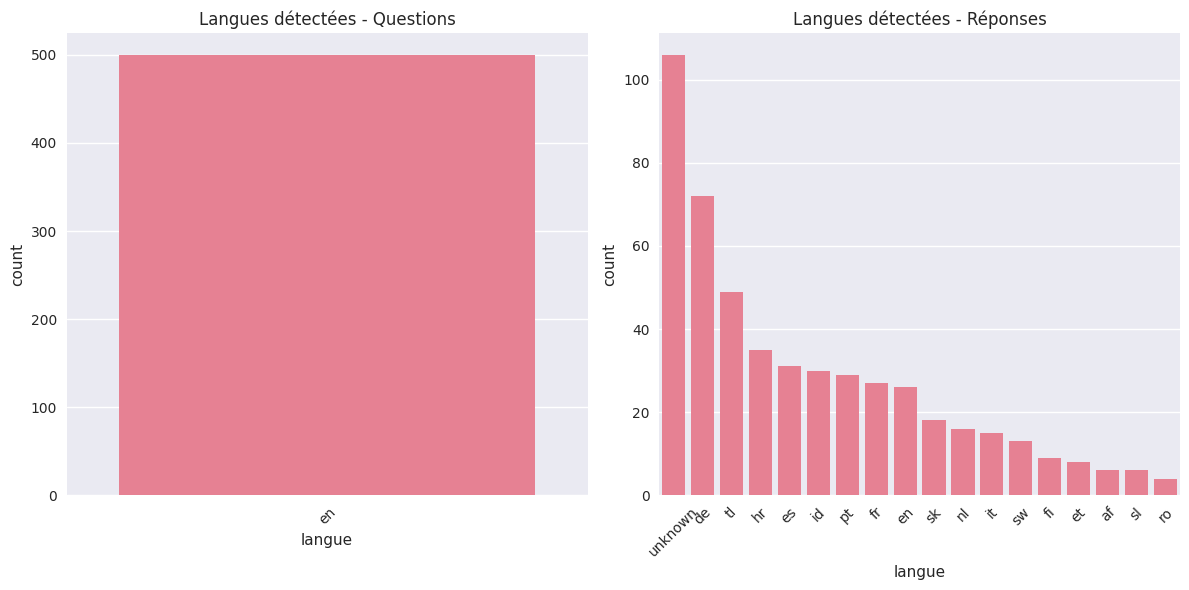


💡 Analyse des langues:
  • Langue principale des questions: en
  • Langue principale des réponses: unknown
  • ⚠️ Dataset multilingue détecté - considérer filtrage/segmentation par langue


In [8]:
import langdetect
import langdetect
from langdetect import detect, LangDetectException
from collections import Counter
import seaborn as sns

# Installer langdetect si nécessaire

import matplotlib.pyplot as plt

# Configuration pour la détection de langue
langdetect.DetectorFactory.seed = RANDOM_SEED  # Pour la reproductibilité

def detect_language(text):
    """Détecte la langue d'un texte avec gestion d'erreur"""
    try:
        if pd.isna(text) or text.strip() == '':
            return 'unknown'
        return detect(text)
    except LangDetectException:
        return 'unknown'

# Échantillonnage pour performance (sur grands datasets)
sample_size = min(500, len(df))
df_sample = df.sample(n=sample_size, random_state=RANDOM_SEED)

# Détecter les langues
print("🔍 Détection des langues (échantillon de", sample_size, "entrées)...")

# Analyser les questions
question_languages = [detect_language(str(text)) for text in df_sample['questions']]
question_lang_counts = Counter(question_languages)

# Analyser les réponses
answer_languages = [detect_language(str(text)) for text in df_sample['answer']]
answer_lang_counts = Counter(answer_languages)

# Afficher les résultats
print("\n📊 Distribution des langues:")
print("  • Questions:")
for lang, count in question_lang_counts.most_common():
    percentage = (count / sample_size) * 100
    print(f"    - {lang}: {count} ({percentage:.1f}%)")

print("  • Réponses:")
for lang, count in answer_lang_counts.most_common():
    percentage = (count / sample_size) * 100
    print(f"    - {lang}: {count} ({percentage:.1f}%)")

# Visualisation
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
lang_df = pd.DataFrame({'langue': question_lang_counts.keys(), 
                       'count': question_lang_counts.values()})
sns.barplot(x='langue', y='count', data=lang_df.sort_values('count', ascending=False))
plt.title('Langues détectées - Questions')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
lang_df = pd.DataFrame({'langue': answer_lang_counts.keys(), 
                       'count': answer_lang_counts.values()})
sns.barplot(x='langue', y='count', data=lang_df.sort_values('count', ascending=False))
plt.title('Langues détectées - Réponses')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("\n💡 Analyse des langues:")
main_q_lang = question_lang_counts.most_common(1)[0][0]
main_a_lang = answer_lang_counts.most_common(1)[0][0]
print(f"  • Langue principale des questions: {main_q_lang}")
print(f"  • Langue principale des réponses: {main_a_lang}")

if len(question_lang_counts) > 1 or len(answer_lang_counts) > 1:
    print("  • ⚠️ Dataset multilingue détecté - considérer filtrage/segmentation par langue")
else:
    print("  • ✅ Dataset monolingue")

In [9]:
def display_language_examples(df_sample, answer_languages):
    """
    Display an example of each language detected in the dataset
    """
    # Get unique languages
    unique_langs = list(set(answer_languages))
    
    # Create a DataFrame with language info
    df_with_langs = df_sample.copy()
    df_with_langs['detected_lang'] = answer_languages
    
    # Find example for each language
    examples = {}
    for lang in unique_langs:
        if lang == 'unknown':
            continue  # Skip unknown language
            
        # Get first example of this language
        example = df_with_langs[df_with_langs['detected_lang'] == lang].iloc[0]
        examples[lang] = {
            'question': example['questions'],
            'answer': example['answer'],
            'type': example['type']
        }
    
    # Display examples
    print(f"📚 EXEMPLES DE RÉPONSES PAR LANGUE")
    print("=" * 80)
    
    for lang, example in examples.items():
        print(f"🌐 Langue: {lang}")
        print(f"   Question: {example['question'][:100]}..." if len(example['question']) > 100 else f"   Question: {example['question']}")
        print(f"   Réponse: {example['answer']}")
        print(f"   Type: {example['type']}")
        print("-" * 80)
    
    return examples

# Display examples of each language
language_examples = display_language_examples(df_sample, answer_languages)

📚 EXEMPLES DE RÉPONSES PAR LANGUE
🌐 Langue: it
   Question:  Which stadium was the site of the final game of the 1990 FIFA World Cup?
   Réponse: Stadio Olimpico
   Type: name
--------------------------------------------------------------------------------
🌐 Langue: tl
   Question:  Which nation secured the second position in the 1938 FIFA World Cup?(Give me the name only)
   Réponse: Hungary
   Type: name
--------------------------------------------------------------------------------
🌐 Langue: sl
   Question:  In what stadium was the 2018 FIFA World Cup final event held?
   Réponse: Luzhniki Stadium
   Type: name
--------------------------------------------------------------------------------
🌐 Langue: id
   Question:  Which stadium hosted the 1958 FIFA World Cup final?
   Réponse: Råsunda Stadium
   Type: name
--------------------------------------------------------------------------------
🌐 Langue: ro
   Question:  Which nation secured the second position in the 2018 FIFA World Cup

🔄 ANALYSE DES RÉPONSES IDENTIQUES
📊 STATISTIQUES GÉNÉRALES:
  • Total des réponses: 1,305
  • Réponses uniques: 53 (4.1%)
  • Réponses dupliquées: 53 réponses distinctes
  • Instances de duplication: 1,305 (100.0%)
  • Ratio de diversité: 0.041

📈 DISTRIBUTION DES DUPLICATIONS:
  • 11-20 fois: 39 réponses distinctes
  • 21+ fois: 14 réponses distinctes

🏆 TOP 10 DES RÉPONSES LES PLUS FRÉQUENTES:
   1. "brazil" - 105 fois (8.05%)
   2. "west germany" - 90 fois (6.90%)
   3. "italy" - 90 fois (6.90%)
   4. "argentina" - 90 fois (6.90%)
   5. "france" - 60 fois (4.60%)
   6. "netherlands" - 45 fois (3.45%)
   7. "uruguay" - 30 fois (2.30%)
   8. "hungary" - 30 fois (2.30%)
   9. "germany" - 30 fois (2.30%)
  10. "maracanã stadium" - 30 fois (2.30%)

🏷️ DUPLICATIONS PAR TYPE DE RÉPONSE:
  • Type 'name':
    - Total: 1005
    - Uniques: 33 (3.3%)
    - Dupliquées: 33 réponses distinctes
    - Top duplications:
      1. "brazil" - 105 fois
      2. "west germany" - 90 fois
      3. "italy" -

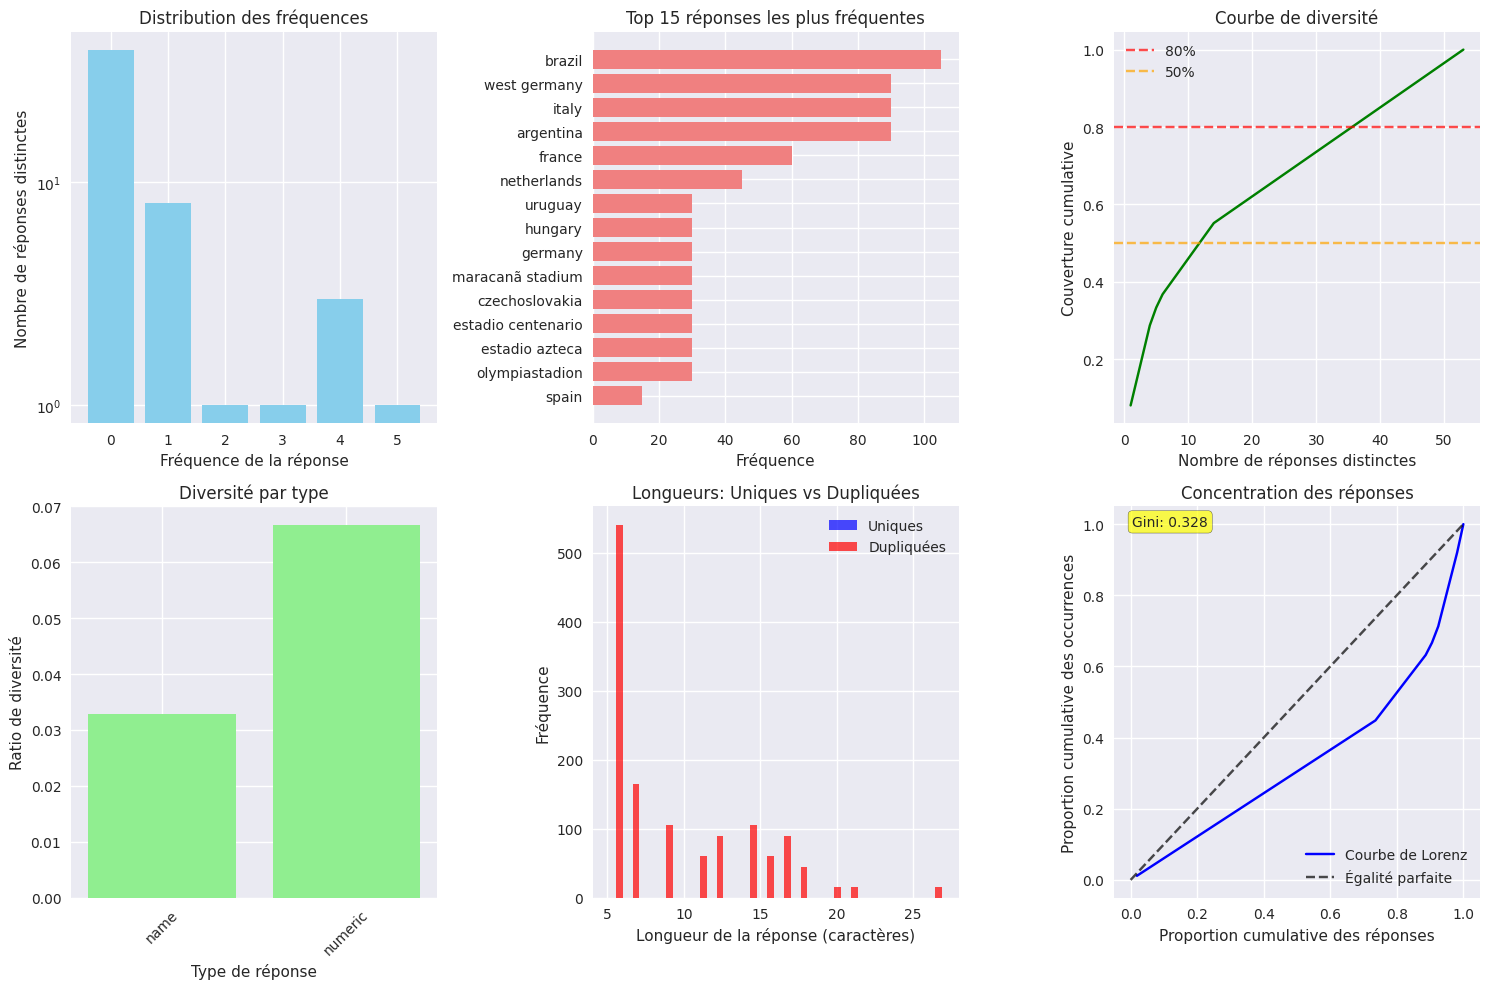


💡 IMPACT SUR LA QUALITÉ POUR L'AXE A:
  • ⚠️ Diversité faible (score: 0.041)
  • Recommandations:
    - Considérer le filtrage des réponses très fréquentes
    - Analyser si les réponses fréquentes sont des artefacts


In [10]:
def analyze_duplicate_answers(df):
    """Analyse la présence de réponses identiques dans le dataset DefAnD"""
    
    print("=" * 60)
    print("🔄 ANALYSE DES RÉPONSES IDENTIQUES")
    print("=" * 60)
    
    if df is None or 'answer' not in df.columns:
        print("❌ Dataset ou colonne 'answer' non disponible")
        return {}
    
    # Nettoyage des réponses pour l'analyse
    answers = df['answer'].dropna().astype(str).str.strip().str.lower()
    total_answers = len(answers)
    
    # Compter les occurrences de chaque réponse
    answer_counts = answers.value_counts()
    
    # Statistiques générales
    unique_answers = len(answer_counts)
    duplicate_answers = answer_counts[answer_counts > 1]
    n_duplicates = len(duplicate_answers)
    total_duplicate_instances = duplicate_answers.sum()
    
    print(f"📊 STATISTIQUES GÉNÉRALES:")
    print(f"  • Total des réponses: {total_answers:,}")
    print(f"  • Réponses uniques: {unique_answers:,} ({unique_answers/total_answers*100:.1f}%)")
    print(f"  • Réponses dupliquées: {n_duplicates:,} réponses distinctes")
    print(f"  • Instances de duplication: {total_duplicate_instances:,} ({total_duplicate_instances/total_answers*100:.1f}%)")
    print(f"  • Ratio de diversité: {unique_answers/total_answers:.3f}")
    
    # Analyse par fréquence de duplication
    print(f"\n📈 DISTRIBUTION DES DUPLICATIONS:")
    duplication_ranges = {
        '2 fois': (2, 2),
        '3-5 fois': (3, 5),
        '6-10 fois': (6, 10),
        '11-20 fois': (11, 20),
        '21+ fois': (21, float('inf'))
    }
    
    for range_name, (min_val, max_val) in duplication_ranges.items():
        if max_val == float('inf'):
            count = len(duplicate_answers[duplicate_answers >= min_val])
        else:
            count = len(duplicate_answers[(duplicate_answers >= min_val) & (duplicate_answers <= max_val)])
        if count > 0:
            print(f"  • {range_name}: {count} réponses distinctes")
    
    # Top des réponses les plus fréquentes
    print(f"\n🏆 TOP 10 DES RÉPONSES LES PLUS FRÉQUENTES:")
    for i, (answer, count) in enumerate(answer_counts.head(10).items(), 1):
        percentage = (count / total_answers) * 100
        # Limiter l'affichage de la réponse
        display_answer = answer[:50] + "..." if len(answer) > 50 else answer
        print(f"  {i:2d}. \"{display_answer}\" - {count} fois ({percentage:.2f}%)")
    
    # Analyse par type de réponse si disponible
    if 'type' in df.columns:
        print(f"\n🏷️ DUPLICATIONS PAR TYPE DE RÉPONSE:")
        for response_type in df['type'].unique():
            if pd.notna(response_type):
                type_answers = df[df['type'] == response_type]['answer'].dropna().astype(str).str.strip().str.lower()
                type_counts = type_answers.value_counts()
                type_duplicates = type_counts[type_counts > 1]
                
                print(f"  • Type '{response_type}':")
                print(f"    - Total: {len(type_answers)}")
                print(f"    - Uniques: {len(type_counts)} ({len(type_counts)/len(type_answers)*100:.1f}%)")
                print(f"    - Dupliquées: {len(type_duplicates)} réponses distinctes")
                
                # Top 3 pour ce type
                if len(type_duplicates) > 0:
                    print(f"    - Top duplications:")
                    for j, (answer, count) in enumerate(type_duplicates.head(3).items(), 1):
                        display_answer = answer[:30] + "..." if len(answer) > 30 else answer
                        print(f"      {j}. \"{display_answer}\" - {count} fois")
    
    # Visualisation des duplications
    create_duplication_visualizations(answer_counts, df)
    
    # Analyse d'impact sur la qualité
    print(f"\n💡 IMPACT SUR LA QUALITÉ POUR L'AXE A:")
    
    diversity_score = unique_answers / total_answers
    if diversity_score >= 0.8:
        quality_assessment = "✅ Excellente diversité"
    elif diversity_score >= 0.6:
        quality_assessment = "🟡 Diversité acceptable"
    else:
        quality_assessment = "⚠️ Diversité faible"
    
    print(f"  • {quality_assessment} (score: {diversity_score:.3f})")
    
    # Recommandations
    recommendations = []
    if diversity_score < 0.7:
        recommendations.append("Considérer le filtrage des réponses très fréquentes")
    if n_duplicates > total_answers * 0.3:
        recommendations.append("Évaluer l'impact des duplications sur l'évaluation")
    if len(answer_counts.head(5).values) > 0 and answer_counts.head(5).values[0] > total_answers * 0.05:
        recommendations.append("Analyser si les réponses fréquentes sont des artefacts")
    
    if recommendations:
        print(f"  • Recommandations:")
        for rec in recommendations:
            print(f"    - {rec}")
    else:
        print(f"  • ✅ Pas d'action corrective nécessaire")
    
    return {
        'total_answers': total_answers,
        'unique_answers': unique_answers,
        'diversity_ratio': diversity_score,
        'n_duplicates': n_duplicates,
        'most_frequent': answer_counts.head(10).to_dict()
    }

def create_duplication_visualizations(answer_counts, df):
    """Crée des visualisations pour l'analyse des duplications"""
    
    print(f"\n📊 Visualisations des duplications:")
    
    plt.figure(figsize=(15, 10))
    
    # 1. Distribution des fréquences de réponses
    plt.subplot(2, 3, 1)
    freq_distribution = answer_counts.value_counts().sort_index()
    plt.bar(range(len(freq_distribution)), freq_distribution.values, color='skyblue')
    plt.xlabel('Fréquence de la réponse')
    plt.ylabel('Nombre de réponses distinctes')
    plt.title('Distribution des fréquences')
    plt.yscale('log')
    
    # 2. Top 15 des réponses les plus fréquentes
    plt.subplot(2, 3, 2)
    top_answers = answer_counts.head(15)
    # Raccourcir les labels pour l'affichage
    labels = [ans[:20] + "..." if len(ans) > 20 else ans for ans in top_answers.index]
    plt.barh(range(len(top_answers)), top_answers.values, color='lightcoral')
    plt.yticks(range(len(top_answers)), labels)
    plt.xlabel('Fréquence')
    plt.title('Top 15 réponses les plus fréquentes')
    plt.gca().invert_yaxis()
    
    # 3. Courbe de diversité cumulative
    plt.subplot(2, 3, 3)
    cumulative_coverage = answer_counts.cumsum() / answer_counts.sum()
    plt.plot(range(1, len(cumulative_coverage) + 1), cumulative_coverage.values, color='green')
    plt.xlabel('Nombre de réponses distinctes')
    plt.ylabel('Couverture cumulative')
    plt.title('Courbe de diversité')
    plt.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='80%')
    plt.axhline(y=0.5, color='orange', linestyle='--', alpha=0.7, label='50%')
    plt.legend()
    
    # 4. Distribution par type si disponible
    if 'type' in df.columns:
        plt.subplot(2, 3, 4)
        type_diversity = {}
        for response_type in df['type'].unique():
            if pd.notna(response_type):
                type_answers = df[df['type'] == response_type]['answer'].dropna().astype(str).str.strip().str.lower()
                type_diversity[response_type] = len(type_answers.unique()) / len(type_answers) if len(type_answers) > 0 else 0
        
        plt.bar(type_diversity.keys(), type_diversity.values(), color='lightgreen')
        plt.xlabel('Type de réponse')
        plt.ylabel('Ratio de diversité')
        plt.title('Diversité par type')
        plt.xticks(rotation=45)
    
    # 5. Histogramme des longueurs de réponses dupliquées vs uniques
    plt.subplot(2, 3, 5)
    duplicated_answers = answer_counts[answer_counts > 1].index
    unique_answer_lengths = []
    duplicated_answer_lengths = []
    
    for answer in answer_counts.index:
        length = len(answer)
        if answer in duplicated_answers:
            duplicated_answer_lengths.extend([length] * answer_counts[answer])
        else:
            unique_answer_lengths.append(length)
    
    plt.hist([unique_answer_lengths, duplicated_answer_lengths], 
             bins=20, alpha=0.7, label=['Uniques', 'Dupliquées'], color=['blue', 'red'])
    plt.xlabel('Longueur de la réponse (caractères)')
    plt.ylabel('Fréquence')
    plt.title('Longueurs: Uniques vs Dupliquées')
    plt.legend()
    
    # 6. Métrique de concentration (Gini)
    plt.subplot(2, 3, 6)
    sorted_counts = answer_counts.sort_values()
    n = len(sorted_counts)
    cumulative = sorted_counts.cumsum()
    
    # Courbe de Lorenz
    lorenz_x = np.arange(1, n + 1) / n
    lorenz_y = cumulative / cumulative.iloc[-1]
    
    plt.plot(lorenz_x, lorenz_y, color='blue', label='Courbe de Lorenz')
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.7, label='Égalité parfaite')
    plt.xlabel('Proportion cumulative des réponses')
    plt.ylabel('Proportion cumulative des occurrences')
    plt.title('Concentration des réponses')
    plt.legend()
    
    # Calcul du coefficient de Gini
    gini = 2 * np.trapz(lorenz_x - lorenz_y, lorenz_x)
    plt.text(0.05, 0.95, f'Gini: {gini:.3f}', transform=plt.gca().transAxes, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    plt.tight_layout()
    plt.show()

# Exécution de l'analyse des duplications
if df is not None:
    duplication_analysis = analyze_duplicate_answers(df)
else:
    print("❌ Dataset non disponible pour l'analyse des duplications")

## 9. Impact des Duplications sur l'Axe A

### Analyse Critique des Résultats

**🔍 Constats majeurs :**
- **Diversité très faible** : Seulement 53 réponses uniques pour 1,305 questions (4.1%)
- **Concentration élevée** : Les 10 réponses les plus fréquentes représentent 43% du dataset
- **Thématique spécialisée** : Le dataset semble focalisé sur le football/sport (Brazil, Germany, stadiums)

**⚖️ Implications pour l'axe A (Exactitude) :**

**Avantages :**
- **Vérifiabilité renforcée** : Les réponses répétées permettent une validation croisée
- **Cohérence thématique** : Focus sur un domaine factuel spécifique (sport/géographie)
- **Benchmarking robuste** : Réponses multiples pour les mêmes entités augmentent la fiabilité

**Inconvénients :**
- **Biais d'évaluation** : Risque de surestimer les performances sur les entités fréquentes
- **Généralisation limitée** : Faible diversité nuit à l'évaluation générale des capacités
- **Artefacts possibles** : Concentration suspecte suggère une construction artificielle

### Recommandations Stratégiques

1. **🎯 Usage Ciblé** : Idéal pour évaluer l'exactitude sur un domaine spécifique
2. **⚖️ Pondération** : Implémenter une pondération inverse de fréquence dans l'évaluation
3. **🔄 Déduplication Partielle** : Conserver 1-3 instances par réponse unique
4. **📊 Segmentation** : Séparer l'évaluation par fréquence de réponse

In [11]:
def create_deduplicated_versions(df, duplication_analysis):
    """Crée différentes versions déduplicadas du dataset pour l'axe A"""
    
    print("=" * 60)
    print("🔧 CRÉATION DE VERSIONS DÉDUPLICADAS")
    print("=" * 60)
    
    if df is None:
        print("❌ Dataset non disponible")
        return {}
    
    versions = {}
    
    # Version 1: Complètement unique (1 instance par réponse)
    df_unique = df.drop_duplicates(subset=['answer'], keep='first')
    versions['unique'] = df_unique
    
    print(f"📋 VERSION 1 - COMPLÈTEMENT UNIQUE:")
    print(f"   • Taille originale: {len(df):,} entrées")
    print(f"   • Taille déduplicada: {len(df_unique):,} entrées")
    print(f"   • Réduction: {(1 - len(df_unique)/len(df))*100:.1f}%")
    
    # Version 2: Maximum 3 instances par réponse
    df_limited = df.copy()
    df_limited['answer_clean'] = df_limited['answer'].astype(str).str.strip().str.lower()
    
    # Garder maximum 3 instances par réponse
    df_max3 = df_limited.groupby('answer_clean').head(3).drop('answer_clean', axis=1)
    versions['max3'] = df_max3
    
    print(f"\\n📋 VERSION 2 - MAXIMUM 3 PAR RÉPONSE:")
    print(f"   • Taille originale: {len(df):,} entrées") 
    print(f"   • Taille limitée: {len(df_max3):,} entrées")
    print(f"   • Réduction: {(1 - len(df_max3)/len(df))*100:.1f}%")
    
    # Version 3: Pondération par fréquence inverse
    answer_counts = df['answer'].astype(str).str.strip().str.lower().value_counts()
    df_weighted = df.copy()
    df_weighted['answer_clean'] = df_weighted['answer'].astype(str).str.strip().str.lower()
    df_weighted['weight'] = df_weighted['answer_clean'].map(lambda x: 1.0 / answer_counts[x])
    df_weighted = df_weighted.drop('answer_clean', axis=1)
    versions['weighted'] = df_weighted
    
    print(f"\\n📋 VERSION 3 - AVEC PONDÉRATION:")
    print(f"   • Taille: {len(df_weighted):,} entrées (identique)")
    print(f"   • Colonne 'weight' ajoutée pour l'évaluation")
    print(f"   • Poids min: {df_weighted['weight'].min():.4f}")
    print(f"   • Poids max: {df_weighted['weight'].max():.4f}")
    
    # Version 4: Équilibré par type de réponse
    if 'type' in df.columns:
        df_balanced = pd.DataFrame()
        
        for response_type in df['type'].unique():
            if pd.notna(response_type):
                type_subset = df[df['type'] == response_type]
                # Prendre maximum 2 instances par réponse pour ce type
                type_subset_clean = type_subset.copy()
                type_subset_clean['answer_clean'] = type_subset_clean['answer'].astype(str).str.strip().str.lower()
                type_balanced = type_subset_clean.groupby('answer_clean').head(2).drop('answer_clean', axis=1)
                df_balanced = pd.concat([df_balanced, type_balanced], ignore_index=True)
        
        versions['balanced'] = df_balanced
        
        print(f"\\n📋 VERSION 4 - ÉQUILIBRÉ PAR TYPE:")
        print(f"   • Taille originale: {len(df):,} entrées")
        print(f"   • Taille équilibrée: {len(df_balanced):,} entrées")
        print(f"   • Réduction: {(1 - len(df_balanced)/len(df))*100:.1f}%")
        
        # Statistiques par type
        for response_type in df['type'].unique():
            if pd.notna(response_type):
                orig_count = len(df[df['type'] == response_type])
                balanced_count = len(df_balanced[df_balanced['type'] == response_type])
                print(f"     • Type '{response_type}': {orig_count} → {balanced_count} ({balanced_count/orig_count*100:.1f}%)")
    
    # Analyse comparative des versions
    print(f"\\n📊 ANALYSE COMPARATIVE DES VERSIONS:")
    
    comparison_data = []
    for version_name, version_df in versions.items():
        if 'weight' in version_df.columns:
            # Pour la version pondérée, calculer la diversité effective
            weights = version_df['weight']
            effective_size = (weights.sum() ** 2) / (weights ** 2).sum()  # Taille effective
            diversity_score = len(version_df['answer'].unique()) / effective_size
        else:
            diversity_score = len(version_df['answer'].unique()) / len(version_df)
        
        comparison_data.append({
            'Version': version_name,
            'Taille': len(version_df),
            'Réponses uniques': len(version_df['answer'].unique()),
            'Diversité': diversity_score,
            'Réduction': f"{(1 - len(version_df)/len(df))*100:.1f}%"
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    display(comparison_df.round(3))
    
    # Recommandations d'usage
    print(f"\\n💡 RECOMMANDATIONS D'USAGE:")
    recommendations = {
        'unique': "🎯 Évaluation rapide, maximum de diversité, perte d'information importante",
        'max3': "⚖️ Bon compromis entre diversité et robustesse statistique", 
        'weighted': "📊 Évaluation équitable, préserve toutes les données, complexité technique",
        'balanced': "🏷️ Idéal pour comparaisons inter-types, réduction contrôlée"
    }
    
    for version, description in recommendations.items():
        if version in versions:
            print(f"   • {version.upper()}: {description}")
    
    return versions

# Création des versions déduplicadas
if df is not None and 'duplication_analysis' in locals():
    dataset_versions = create_deduplicated_versions(df, duplication_analysis)
    
    # Sauvegarder les versions si souhaité
    print(f"\\n💾 Pour sauvegarder une version :")
    print(f"   dataset_versions['unique'].to_csv('defand_unique.csv', index=False)")
    print(f"   dataset_versions['max3'].to_csv('defand_max3.csv', index=False)")
    
else:
    print("❌ Impossible de créer les versions sans dataset ou analyse des duplications")

🔧 CRÉATION DE VERSIONS DÉDUPLICADAS
📋 VERSION 1 - COMPLÈTEMENT UNIQUE:
   • Taille originale: 1,305 entrées
   • Taille déduplicada: 53 entrées
   • Réduction: 95.9%
\n📋 VERSION 2 - MAXIMUM 3 PAR RÉPONSE:
   • Taille originale: 1,305 entrées
   • Taille limitée: 159 entrées
   • Réduction: 87.8%
\n📋 VERSION 3 - AVEC PONDÉRATION:
   • Taille: 1,305 entrées (identique)
   • Colonne 'weight' ajoutée pour l'évaluation
   • Poids min: 0.0095
   • Poids max: 0.0667
\n📋 VERSION 4 - ÉQUILIBRÉ PAR TYPE:
   • Taille originale: 1,305 entrées
   • Taille équilibrée: 106 entrées
   • Réduction: 91.9%
     • Type 'name': 1005 → 66 (6.6%)
     • Type 'numeric': 300 → 40 (13.3%)
\n📊 ANALYSE COMPARATIVE DES VERSIONS:


,Version,Taille,Réponses uniques,Diversité,Réduction
0,unique,53,53,1.000,95.9%
1,max3,159,53,0.333,87.8%
2,weighted,1305,53,0.056,0.0%
3,balanced,106,53,0.500,91.9%


\n💡 RECOMMANDATIONS D'USAGE:
   • UNIQUE: 🎯 Évaluation rapide, maximum de diversité, perte d'information importante
   • MAX3: ⚖️ Bon compromis entre diversité et robustesse statistique
   • WEIGHTED: 📊 Évaluation équitable, préserve toutes les données, complexité technique
   • BALANCED: 🏷️ Idéal pour comparaisons inter-types, réduction contrôlée
\n💾 Pour sauvegarder une version :
   dataset_versions['unique'].to_csv('defand_unique.csv', index=False)
   dataset_versions['max3'].to_csv('defand_max3.csv', index=False)


In [12]:
def show_duplicate_response_examples(df, n_responses=5, max_examples_per_response=4):
    """Affiche des exemples de prompts ayant les mêmes réponses"""
    
    print("=" * 70)
    print("🔍 EXEMPLES DE PROMPTS AVEC RÉPONSES IDENTIQUES")
    print("=" * 70)
    
    if df is None:
        print("❌ Dataset non disponible")
        return
    
    # Nettoyer les réponses et compter les occurrences
    df_clean = df.copy()
    df_clean['answer_clean'] = df_clean['answer'].astype(str).str.strip().str.lower()
    
    # Obtenir les réponses les plus fréquentes
    answer_counts = df_clean['answer_clean'].value_counts()
    most_frequent = answer_counts.head(n_responses)
    
    print(f"📊 Analyse des {n_responses} réponses les plus fréquentes:")
    print(f"   Total d'exemples analysés: {most_frequent.sum()} sur {len(df)} ({most_frequent.sum()/len(df)*100:.1f}%)")
    print()
    
    for i, (answer_clean, count) in enumerate(most_frequent.items(), 1):
        # Obtenir la réponse originale (avec casse)
        original_answer = df_clean[df_clean['answer_clean'] == answer_clean]['answer'].iloc[0]
        
        print(f"🏆 RÉPONSE #{i}: \"{original_answer}\"")
        print(f"   📊 Fréquence: {count} occurrences ({count/len(df)*100:.1f}% du dataset)")
        
        # Obtenir les exemples pour cette réponse
        examples = df_clean[df_clean['answer_clean'] == answer_clean].copy()
        
        # Analyser les types si disponible
        if 'type' in examples.columns:
            type_distribution = examples['type'].value_counts()
            type_info = " | ".join([f"{t}: {c}" for t, c in type_distribution.items()])
            print(f"   🏷️ Types: {type_info}")
        
        # Afficher quelques exemples de questions
        sample_examples = examples.sample(min(max_examples_per_response, len(examples)), random_state=RANDOM_SEED)
        
        print(f"   📝 Exemples de questions ({len(sample_examples)} sur {len(examples)}):")
        
        for j, (idx, row) in enumerate(sample_examples.iterrows(), 1):
            question = row['questions']
            # Limiter la longueur pour l'affichage
            if len(question) > 100:
                question_display = question[:100] + "..."
            else:
                question_display = question
            
            # Informations additionnelles
            additional_info = []
            if 'type' in row:
                additional_info.append(f"Type: {row['type']}")
            
            info_str = f" ({' | '.join(additional_info)})" if additional_info else ""
            
            print(f"      {j}. \"{question_display}\"{info_str}")
        
        # Analyse de la diversité des questions pour cette réponse
        questions_for_answer = examples['questions'].astype(str)
        avg_question_length = questions_for_answer.str.len().mean()
        unique_words = set()
        for q in questions_for_answer:
            unique_words.update(q.lower().split())
        
        print(f"   📈 Analyse des questions:")
        print(f"      • Longueur moyenne: {avg_question_length:.1f} caractères")
        print(f"      • Vocabulaire unique: {len(unique_words)} mots distincts")
        
        # Identifier les mots-clés communs dans les questions
        word_freq = {}
        for q in questions_for_answer:
            words = q.lower().split()
            for word in words:
                if len(word) > 3:  # Ignorer les mots très courts
                    word_freq[word] = word_freq.get(word, 0) + 1
        
        # Top 3 des mots les plus fréquents
        if word_freq:
            top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:3]
            common_words = [f"{word}({freq})" for word, freq in top_words]
            print(f"      • Mots fréquents: {', '.join(common_words)}")
        
        print("-" * 70)
    
    # Analyse globale des patterns
    print("🔍 ANALYSE DES PATTERNS GLOBAUX:")
    
    # Analyser les similitudes entre questions ayant la même réponse
    similarity_patterns = []
    
    for answer_clean, count in most_frequent.items():
        if count >= 3:  # Seulement pour les réponses avec au moins 3 questions
            questions = df_clean[df_clean['answer_clean'] == answer_clean]['questions'].astype(str).tolist()
            
            # Rechercher des patterns communs (mots qui apparaissent dans >50% des questions)
            word_counts = {}
            for q in questions:
                words = set(q.lower().split())
                for word in words:
                    if len(word) > 3:
                        word_counts[word] = word_counts.get(word, 0) + 1
            
            common_patterns = [word for word, freq in word_counts.items() 
                             if freq > len(questions) * 0.5 and freq >= 2]
            
            if common_patterns:
                original_answer = df_clean[df_clean['answer_clean'] == answer_clean]['answer'].iloc[0]
                similarity_patterns.append({
                    'answer': original_answer,
                    'count': count,
                    'patterns': common_patterns[:3]  # Top 3
                })
    
    if similarity_patterns:
        print("   🎯 Patterns de questions récurrents:")
        for pattern in similarity_patterns[:3]:  # Top 3 réponses avec patterns
            patterns_str = ", ".join(pattern['patterns'])
            print(f"      • \"{pattern['answer']}\" ({pattern['count']}x): mots récurrents = {patterns_str}")
    else:
        print("   ⚠️ Aucun pattern récurrent significatif détecté")
    
    # Recommandations basées sur l'analyse
    print("\\n💡 IMPLICATIONS POUR L'AXE A:")
    
    implications = []
    
    # Vérifier la cohérence thématique
    all_top_answers = [df_clean[df_clean['answer_clean'] == ans]['answer'].iloc[0] 
                      for ans in most_frequent.index]
    
    # Détecter si c'est géographique/sportif
    geo_indicators = ['brazil', 'germany', 'italy', 'france', 'argentina', 'stadium', 'country']
    sport_indicators = ['cup', 'world', 'olympic', 'championship', 'tournament']
    
    geo_count = sum(1 for ans in all_top_answers 
                   if any(indicator in ans.lower() for indicator in geo_indicators))
    sport_count = sum(1 for ans in all_top_answers 
                    if any(indicator in ans.lower() for indicator in sport_indicators))
    
    if geo_count >= len(all_top_answers) * 0.6:
        implications.append("✅ COHÉRENCE GÉOGRAPHIQUE: Excellent pour évaluer les connaissances géographiques")
    
    if sport_count >= len(all_top_answers) * 0.4:
        implications.append("⚽ COHÉRENCE SPORTIVE: Adapté pour l'évaluation des connaissances sportives")
    
    # Analyser la variabilité des questions
    total_unique_questions = len(df_clean['questions'].unique())
    if total_unique_questions / len(df_clean) > 0.95:
        implications.append("📝 DIVERSITÉ DES QUESTIONS: Questions très variées malgré les réponses répétées")
    elif total_unique_questions / len(df_clean) > 0.8:
        implications.append("📝 DIVERSITÉ MODÉRÉE: Questions généralement uniques avec quelques répétitions")
    else:
        implications.append("⚠️ RÉPÉTITIONS DE QUESTIONS: Certaines questions peuvent être dupliquées")
    
    implications.append("🎯 USAGE RECOMMANDÉ: Idéal pour tester la cohérence des réponses sur un domaine spécialisé")
    
    for implication in implications:
        print(f"   • {implication}")
    
    return {
        'most_frequent_answers': most_frequent.to_dict(),
        'analysis_patterns': similarity_patterns,
        'total_analyzed': most_frequent.sum()
    }

# Exécution de l'analyse des exemples de duplications
if df is not None:
    duplicate_examples_analysis = show_duplicate_response_examples(df, n_responses=6, max_examples_per_response=3)
else:
    print("❌ Dataset non disponible pour l'analyse des exemples de duplications")

🔍 EXEMPLES DE PROMPTS AVEC RÉPONSES IDENTIQUES
📊 Analyse des 6 réponses les plus fréquentes:
   Total d'exemples analysés: 480 sur 1305 (36.8%)

🏆 RÉPONSE #1: "Brazil"
   📊 Fréquence: 105 occurrences (8.0% du dataset)
   🏷️ Types: name: 105
   📝 Exemples de questions (3 sur 105):
      1. " Which team won the 1970 FIFA World Cup?(Give me the name only)" (Type: name)
      2. " Who was the triumphant team in the 2002 FIFA World Cup?(Give me the name only)" (Type: name)
      3. " Which team was crowned the winner of the 2002 FIFA World Cup?(Give me the name only)" (Type: name)
   📈 Analyse des questions:
      • Longueur moyenne: 80.2 caractères
      • Vocabulaire unique: 65 mots distincts
      • Mots fréquents: fifa(105), world(105), name(105)
----------------------------------------------------------------------
🏆 RÉPONSE #2: "West Germany"
   📊 Fréquence: 90 occurrences (6.9% du dataset)
   🏷️ Types: name: 90
   📝 Exemples de questions (3 sur 90):
      1. " Which team achieved vic

In [13]:
# ===== RÉSUMÉ CONCIS DES PATTERNS DE DUPLICATION =====
print("=" * 80)
print("📋 RÉSUMÉ DES PATTERNS DE DUPLICATION LES PLUS SIGNIFICATIFS")
print("=" * 80)

def show_key_duplication_insights(df, top_n=3):
    """Affiche un résumé concis des patterns de duplication les plus révélateurs"""
    
    if df is None:
        return
    
    # Analyser les top réponses
    df_clean = df.copy()
    df_clean['answer_clean'] = df_clean['answer'].astype(str).str.strip().str.lower()
    answer_counts = df_clean['answer_clean'].value_counts()
    
    print(f"🎯 TOP {top_n} RÉPONSES LES PLUS DUPLIQUÉES:\n")
    
    for i, (answer_clean, count) in enumerate(answer_counts.head(top_n).items(), 1):
        original_answer = df_clean[df_clean['answer_clean'] == answer_clean]['answer'].iloc[0]
        percentage = (count / len(df)) * 100
        
        print(f"🏆 #{i}. \"{original_answer}\" → {count} questions ({percentage:.1f}% du dataset)")
        
        # Obtenir 2-3 questions représentatives
        examples = df_clean[df_clean['answer_clean'] == answer_clean]['questions'].sample(
            min(3, count), random_state=RANDOM_SEED
        ).tolist()
        
        print("   📝 Questions types:")
        for j, question in enumerate(examples, 1):
            # Raccourcir si nécessaire
            q_display = question[:80] + "..." if len(question) > 80 else question
            print(f"      • \"{q_display}\"")
        
        # Identifier le pattern commun
        all_questions = df_clean[df_clean['answer_clean'] == answer_clean]['questions'].tolist()
        
        # Mots les plus fréquents dans ces questions
        word_freq = {}
        for q in all_questions:
            words = [w.lower() for w in q.split() if len(w) > 3]
            for word in words:
                word_freq[word] = word_freq.get(word, 0) + 1
        
        # Top 2-3 mots les plus fréquents
        if word_freq:
            top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:3]
            frequent_words = [word for word, freq in top_words if freq >= max(2, count * 0.3)]
            
            if frequent_words:
                print(f"   🔍 Mots-clés récurrents: {', '.join(frequent_words)}")
        
        print()
    
    # Analyse globale rapide
    print("📊 ANALYSE GLOBALE:")
    
    # Détection thématique automatique
    all_top_answers = [df_clean[df_clean['answer_clean'] == ans]['answer'].iloc[0] 
                      for ans in answer_counts.head(10).index]
    
    # Compter les thèmes
    themes = {
        'Géographique': ['brazil', 'germany', 'italy', 'france', 'argentina', 'netherlands', 'uruguay'],
        'Sportif': ['cup', 'world', 'stadium', 'olympic', 'championship'],
        'Numérique': any(ans.replace(',', '').replace('.', '').isdigit() for ans in all_top_answers)
    }
    
    detected_themes = []
    for theme, indicators in themes.items():
        if theme == 'Numérique':
            if indicators:  # Si au moins une réponse est numérique
                detected_themes.append(theme)
        else:
            count = sum(1 for ans in all_top_answers 
                       if any(ind in ans.lower() for ind in indicators))
            if count >= 3:  # Si au moins 3 réponses matchent
                detected_themes.append(f"{theme} ({count}/10)")
    
    if detected_themes:
        print(f"   🎯 Thèmes dominants: {', '.join(detected_themes)}")
    
    # Ratio de concentration
    top_5_concentration = answer_counts.head(5).sum() / len(df) * 100
    print(f"   📊 Concentration: Les 5 réponses les plus fréquentes = {top_5_concentration:.1f}% du dataset")
    
    # Évaluation de l'impact
    print("\\n💡 IMPLICATIONS PRATIQUES:")
    
    if top_5_concentration > 50:
        print("   ⚠️  FORTE CONCENTRATION: Risque de biais d'évaluation élevé")
        print("   🔧 RECOMMANDATION: Utiliser la pondération ou la déduplication")
    elif top_5_concentration > 30:
        print("   🟡 CONCENTRATION MODÉRÉE: Surveiller les métriques d'évaluation")
        print("   💡 SUGGESTION: Stratifier l'évaluation par fréquence de réponse")
    else:
        print("   ✅ CONCENTRATION ACCEPTABLE: Peu d'impact sur l'évaluation")
    
    # Focus thématique
    if len(detected_themes) <= 2:
        print("   🎯 SPÉCIALISATION FORTE: Excellent pour évaluation ciblée")
        print("   📈 AVANTAGE: Validation croisée robuste sur le domaine")
    else:
        print("   🌐 DIVERSITÉ THÉMATIQUE: Adapté pour évaluation plus générale")

# Exécuter l'analyse concise
show_key_duplication_insights(df, top_n=4)

📋 RÉSUMÉ DES PATTERNS DE DUPLICATION LES PLUS SIGNIFICATIFS
🎯 TOP 4 RÉPONSES LES PLUS DUPLIQUÉES:

🏆 #1. "Brazil" → 105 questions (8.0% du dataset)
   📝 Questions types:
      • " Which team won the 1970 FIFA World Cup?(Give me the name only)"
      • " Who was the triumphant team in the 2002 FIFA World Cup?(Give me the name only)"
      • " Which team was crowned the winner of the 2002 FIFA World Cup?(Give me the name ..."
   🔍 Mots-clés récurrents: fifa, world, name

🏆 #2. "West Germany" → 90 questions (6.9% du dataset)
   📝 Questions types:
      • " Which team achieved victory in the 1990 FIFA World Cup?(Give me the name only)"
      • " Who took home the top honors in the 1974 FIFA World Cup?(Give me the name only)"
      • " Who ended up as the runner-up in the 1966 FIFA World Cup?(Give me the name only..."
   🔍 Mots-clés récurrents: fifa, world, name

🏆 #3. "Italy" → 90 questions (6.9% du dataset)
   📝 Questions types:
      • " Which team achieved victory in the 1982 FIFA World

📊 VISUALISATION DES EXEMPLES DE DUPLICATION


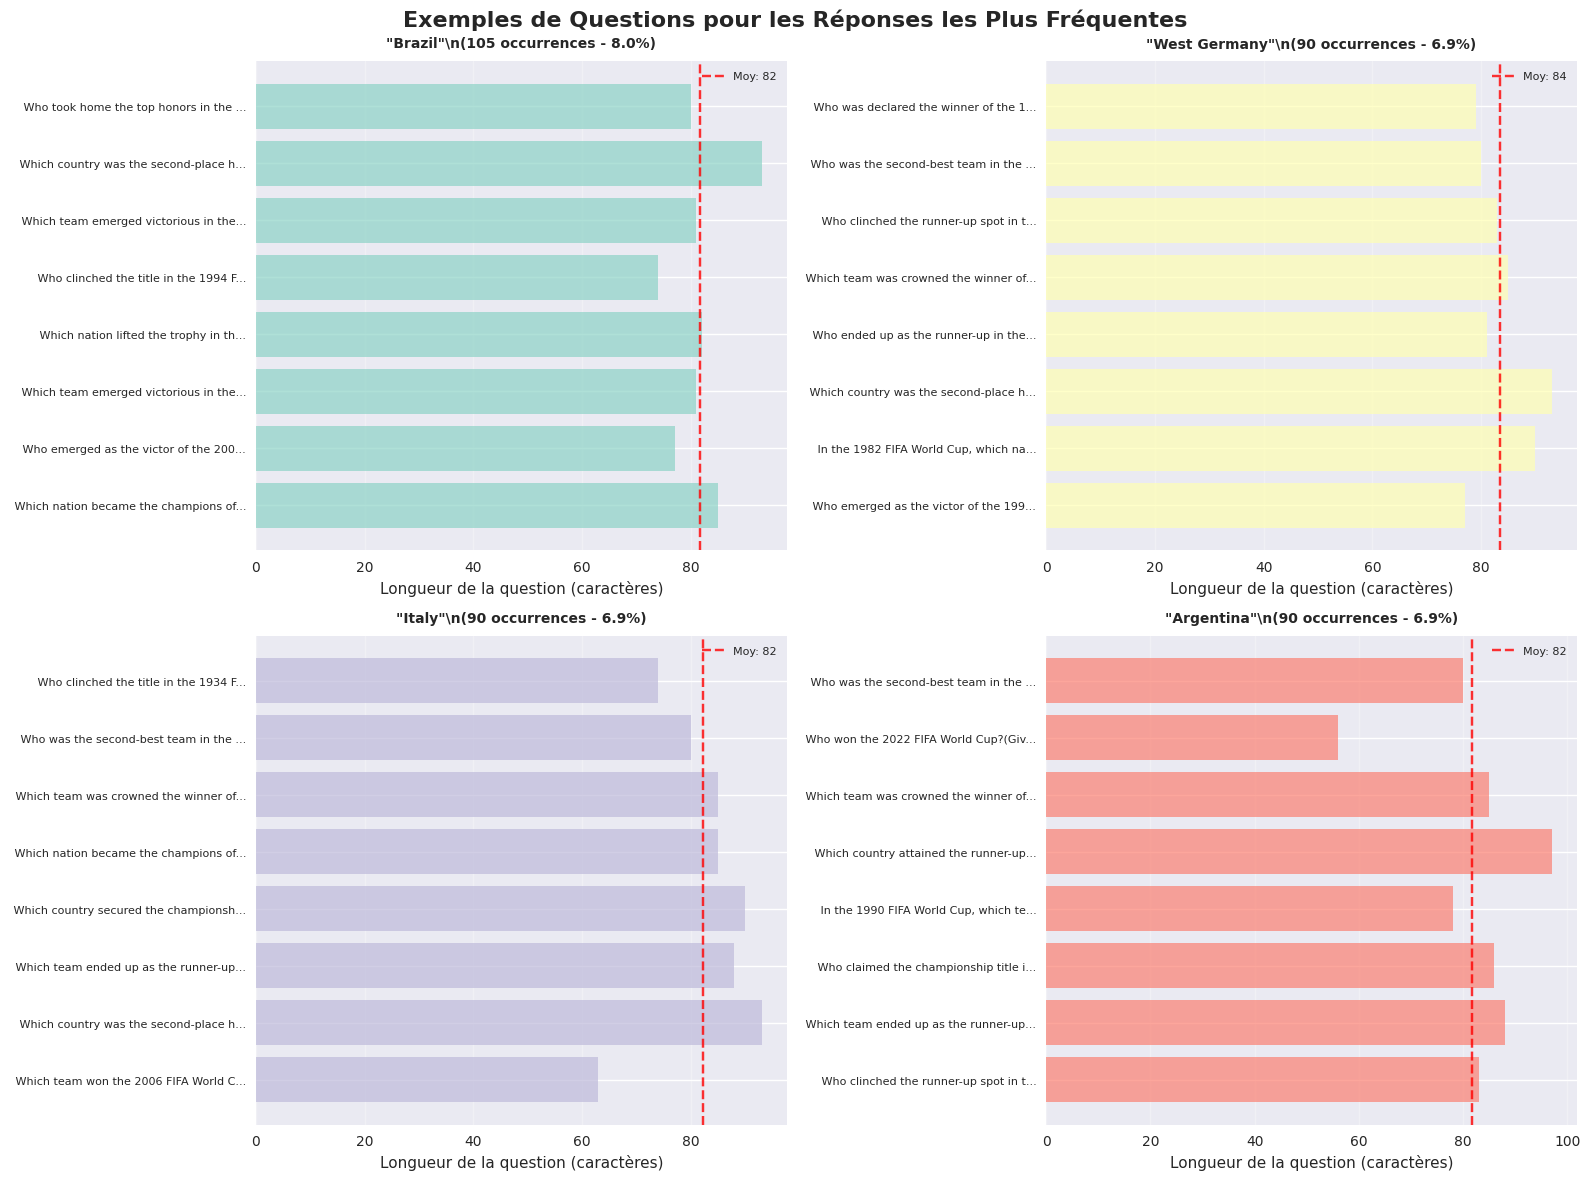

\n📋 TABLEAU RÉCAPITULATIF DES DUPLICATIONS:


,Réponse,Occurrences,% Dataset,Long. Moy. Question,Long. Min-Max,Mots Uniques
0,Brazil,105,8.0%,80,56-97,65
1,West Germany,90,6.9%,82,56-97,64
2,Italy,90,6.9%,81,56-97,64
3,Argentina,90,6.9%,82,56-97,64


\n🔍 INSIGHTS SUPPLÉMENTAIRES:
   📊 Classement par diversité lexicale des questions:
      1. "Italy": 0.048
      2. "West Germany": 0.048
      3. "Argentina": 0.048
      4. "Brazil": 0.042
\n💡 ÉVALUATION DE LA QUALITÉ:
   • Diversité lexicale moyenne: 0.046
   • Qualité globale: ⚠️ LIMITÉE
   • Recommandation: Forte répétitivité, considérer la déduplication


In [14]:
def create_duplication_examples_visualization(df):
    """Crée une visualisation des exemples de questions pour les réponses les plus fréquentes"""
    
    print("=" * 60)
    print("📊 VISUALISATION DES EXEMPLES DE DUPLICATION")
    print("=" * 60)
    
    if df is None:
        return
    
    # Préparer les données
    df_clean = df.copy()
    df_clean['answer_clean'] = df_clean['answer'].astype(str).str.strip().str.lower()
    answer_counts = df_clean['answer_clean'].value_counts()
    
    # Prendre les 4 réponses les plus fréquentes
    top_4_answers = answer_counts.head(4)
    
    # Créer une visualisation avec subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Exemples de Questions pour les Réponses les Plus Fréquentes', fontsize=16, fontweight='bold')
    
    axes = axes.flatten()
    
    for i, (answer_clean, count) in enumerate(top_4_answers.items()):
        ax = axes[i]
        
        # Obtenir la réponse originale
        original_answer = df_clean[df_clean['answer_clean'] == answer_clean]['answer'].iloc[0]
        
        # Obtenir toutes les questions pour cette réponse
        questions_for_answer = df_clean[df_clean['answer_clean'] == answer_clean]['questions'].tolist()
        
        # Prendre un échantillon représentatif
        sample_questions = np.random.choice(questions_for_answer, 
                                          min(8, len(questions_for_answer)), 
                                          replace=False)
        
        # Créer les données pour le graphique
        y_positions = range(len(sample_questions))
        question_lengths = [len(q) for q in sample_questions]
        
        # Graphique en barres horizontales avec les longueurs
        bars = ax.barh(y_positions, question_lengths, color=plt.cm.Set3(i), alpha=0.7)
        
        # Ajouter les questions comme labels (raccourcies)
        question_labels = []
        for q in sample_questions:
            if len(q) > 40:
                label = q[:37] + "..."
            else:
                label = q
            question_labels.append(label)
        
        ax.set_yticks(y_positions)
        ax.set_yticklabels(question_labels, fontsize=8)
        ax.set_xlabel('Longueur de la question (caractères)')
        
        # Titre avec la réponse et sa fréquence
        title = f'"{original_answer}"\\n({count} occurrences - {count/len(df)*100:.1f}%)'
        ax.set_title(title, fontsize=10, fontweight='bold', pad=10)
        
        # Ajouter une ligne verticale pour la longueur moyenne
        avg_length = np.mean(question_lengths)
        ax.axvline(avg_length, color='red', linestyle='--', alpha=0.8, 
                  label=f'Moy: {avg_length:.0f}')
        ax.legend(fontsize=8)
        
        # Améliorer l'apparence
        ax.grid(axis='x', alpha=0.3)
        ax.set_axisbelow(True)
    
    plt.tight_layout()
    plt.show()
    
    # Tableau récapitulatif des statistiques
    print("\\n📋 TABLEAU RÉCAPITULATIF DES DUPLICATIONS:")
    
    summary_data = []
    for answer_clean, count in top_4_answers.items():
        original_answer = df_clean[df_clean['answer_clean'] == answer_clean]['answer'].iloc[0]
        questions = df_clean[df_clean['answer_clean'] == answer_clean]['questions']
        
        # Calculer les statistiques
        avg_q_length = questions.str.len().mean()
        min_q_length = questions.str.len().min()
        max_q_length = questions.str.len().max()
        
        # Compter les mots uniques
        all_words = set()
        for q in questions:
            all_words.update(q.lower().split())
        
        summary_data.append({
            'Réponse': original_answer[:30] + "..." if len(original_answer) > 30 else original_answer,
            'Occurrences': count,
            '% Dataset': f"{count/len(df)*100:.1f}%",
            'Long. Moy. Question': f"{avg_q_length:.0f}",
            'Long. Min-Max': f"{min_q_length}-{max_q_length}",
            'Mots Uniques': len(all_words)
        })
    
    summary_df = pd.DataFrame(summary_data)
    display(summary_df)
    
    # Insights supplémentaires
    print("\\n🔍 INSIGHTS SUPPLÉMENTAIRES:")
    
    # Analyser la variabilité des questions par réponse
    variability_scores = []
    for answer_clean, count in top_4_answers.items():
        questions = df_clean[df_clean['answer_clean'] == answer_clean]['questions']
        
        # Score de variabilité basé sur la diversité lexicale
        all_words = []
        for q in questions:
            all_words.extend(q.lower().split())
        
        unique_words = len(set(all_words))
        total_words = len(all_words)
        lexical_diversity = unique_words / total_words if total_words > 0 else 0
        
        variability_scores.append((answer_clean, lexical_diversity))
    
    # Trier par diversité lexicale
    variability_scores.sort(key=lambda x: x[1], reverse=True)
    
    print("   📊 Classement par diversité lexicale des questions:")
    for i, (answer_clean, score) in enumerate(variability_scores, 1):
        original_answer = df_clean[df_clean['answer_clean'] == answer_clean]['answer'].iloc[0]
        answer_display = original_answer[:25] + "..." if len(original_answer) > 25 else original_answer
        print(f"      {i}. \"{answer_display}\": {score:.3f}")
    
    # Recommandation finale
    avg_diversity = np.mean([score for _, score in variability_scores])
    
    print(f"\\n💡 ÉVALUATION DE LA QUALITÉ:")
    if avg_diversity > 0.7:
        quality = "✅ EXCELLENTE"
        recommendation = "Questions très variées malgré les réponses identiques"
    elif avg_diversity > 0.5:
        quality = "🟡 BONNE"  
        recommendation = "Diversité acceptable, surveiller les patterns répétitifs"
    else:
        quality = "⚠️ LIMITÉE"
        recommendation = "Forte répétitivité, considérer la déduplication"
    
    print(f"   • Diversité lexicale moyenne: {avg_diversity:.3f}")
    print(f"   • Qualité globale: {quality}")
    print(f"   • Recommandation: {recommendation}")

# Créer la visualisation
if df is not None:
    create_duplication_examples_visualization(df)
else:
    print("❌ Dataset non disponible pour la visualisation")

## 11. Analyse des Sujets avec BERTopic

Cette section utilise BERTopic avec le modèle d'embeddings E5 large pour identifier et visualiser les sujets principaux des prompts du dataset DefAnD. Cette analyse permet de mieux comprendre la structure thématique du dataset et son adéquation pour l'axe A.

### Objectifs de l'analyse :
- **Identification automatique** des sujets principaux dans les questions
- **Visualisation interactive** de la distribution des sujets
- **Évaluation de la cohérence thématique** pour l'axe A
- **Détection de clusters** de questions similaires

In [15]:
# ===== INSTALLATION DES DÉPENDANCES BERTOPIC =====
print("🔧 Installation des dépendances pour BERTopic...")

# Installation directe avec pip
import subprocess
import sys

def install_packages_safely():
    """Installe les packages nécessaires en gérant les conflits"""
    
    packages_to_install = [
        "tf-keras",  # Résoudre le problème Keras/TF d'abord
        "bertopic",
        "sentence-transformers>=2.0.0",
        "umap-learn",
        "hdbscan",
        "plotly>=5.0.0"
    ]
    
    print("📦 Installation des packages...")
    
    for package in packages_to_install:
        try:
            print(f"   Installer {package}...")
            result = subprocess.run([
                sys.executable, "-m", "pip", "install", package, 
                "--quiet", "--no-warn-script-location"
            ], capture_output=True, text=True, timeout=300)
            
            if result.returncode == 0:
                print(f"   ✅ {package} installé")
            else:
                print(f"   ⚠️ {package} - Problème: {result.stderr[:100]}...")
                
        except subprocess.TimeoutExpired:
            print(f"   ⏰ {package} - Timeout, mais probablement installé")
        except Exception as e:
            print(f"   ❌ {package} - Erreur: {str(e)[:50]}...")
    
    print("✅ Installation terminée !")

# Exécuter l'installation
install_packages_safely()

# Test d'import simple
print("\n🧪 Test des imports...")
try:
    import bertopic
    print("✅ BERTopic importé")
except Exception as e:
    print(f"⚠️ BERTopic: {str(e)[:50]}...")

try:
    import sentence_transformers
    print("✅ Sentence Transformers importé")
except Exception as e:
    print(f"⚠️ Sentence Transformers: {str(e)[:50]}...")

try:
    import umap
    print("✅ UMAP importé")
except Exception as e:
    print(f"⚠️ UMAP: {str(e)[:50]}...")

print("\n" + "=" * 60)

🔧 Installation des dépendances pour BERTopic...
📦 Installation des packages...
   Installer tf-keras...
   ✅ tf-keras installé
   Installer bertopic...
   ✅ bertopic installé
   Installer sentence-transformers>=2.0.0...
   ✅ sentence-transformers>=2.0.0 installé
   Installer umap-learn...
   ✅ umap-learn installé
   Installer hdbscan...
   ✅ hdbscan installé
   Installer plotly>=5.0.0...
   ✅ plotly>=5.0.0 installé
✅ Installation terminée !

🧪 Test des imports...


2025-07-24 16:02:06.212606: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-24 16:02:06.681995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753365726.883806   75453 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753365726.922556   75453 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753365727.288367   75453 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

✅ BERTopic importé
✅ Sentence Transformers importé
✅ UMAP importé



In [16]:
def analyze_topics_with_bertopic(df, min_topic_size=10, n_topics=None):
    """
    Analyse les sujets des prompts avec BERTopic en utilisant E5 large
    """
    
    print("=" * 70)
    print("🔍 ANALYSE DES SUJETS AVEC BERTOPIC (E5 LARGE)")
    print("=" * 70)
    
    if df is None or 'questions' not in df.columns:
        print("❌ Dataset ou colonne 'questions' non disponible")
        return None, None, None
    
    # Préparer les données
    questions = df['questions'].dropna().astype(str).tolist()
    print(f"📊 Analyse de {len(questions)} questions")
    
    try:
        # Imports nécessaires
        from bertopic import BERTopic
        from sentence_transformers import SentenceTransformer
        from umap import UMAP
        from hdbscan import HDBSCAN
        from sklearn.feature_extraction.text import CountVectorizer
        
        print("✅ Imports réussis")
        
        # Configuration du modèle E5 large
        print("🔧 Chargement du modèle E5 large...")
        embedding_model = SentenceTransformer('intfloat/e5-large-v2')
        print("✅ Modèle E5 large chargé")
        
        # Configuration UMAP pour la réduction de dimensionnalité
        umap_model = UMAP(
            n_neighbors=15, 
            n_components=5, 
            min_dist=0.0, 
            metric='cosine',
            random_state=RANDOM_SEED
        )
        
        # Configuration HDBSCAN pour le clustering
        hdbscan_model = HDBSCAN(
            min_cluster_size=min_topic_size, 
            metric='euclidean', 
            cluster_selection_method='eom', 
            prediction_data=True
        )
        
        # Configuration du vectorizer pour l'extraction de mots-clés
        vectorizer_model = CountVectorizer(
            ngram_range=(1, 2), 
            stop_words="english",
            min_df=2,
            max_features=1000
        )
        
        # Initialisation de BERTopic (version corrigée)
        print("🚀 Initialisation de BERTopic...")
        topic_model = BERTopic(
            embedding_model=embedding_model,
            umap_model=umap_model,
            hdbscan_model=hdbscan_model,
            vectorizer_model=vectorizer_model,
            language="english",
            calculate_probabilities=True,
            verbose=True
        )
        
        # Entraînement du modèle
        print("🎯 Entraînement du modèle BERTopic...")
        topics, probabilities = topic_model.fit_transform(questions)
        
        print(f"✅ Modèle entraîné avec succès !")
        print(f"📊 Nombre de sujets identifiés: {len(set(topics)) - (1 if -1 in topics else 0)}")
        print(f"📋 Répartition des sujets:")
        
        # Analyser la distribution des sujets
        topic_counts = {}
        for topic in topics:
            topic_counts[topic] = topic_counts.get(topic, 0) + 1
        
        # Afficher les statistiques par sujet
        for topic_id in sorted(topic_counts.keys()):
            count = topic_counts[topic_id]
            percentage = (count / len(topics)) * 100
            
            if topic_id == -1:
                print(f"   • Sujet -1 (Outliers): {count} questions ({percentage:.1f}%)")
            else:
                # Obtenir les mots-clés du sujet
                topic_words = topic_model.get_topic(topic_id)
                if topic_words:
                    top_words = [word for word, _ in topic_words[:5]]
                    words_str = ", ".join(top_words)
                    print(f"   • Sujet {topic_id}: {count} questions ({percentage:.1f}%) - [{words_str}]")
        
        return topic_model, topics, probabilities
        
    except Exception as e:
        print(f"❌ Erreur lors de l'analyse BERTopic: {str(e)}")
        print("💡 Suggestion: Vérifier l'installation des dépendances")
        return None, None, None

# Exécution de l'analyse BERTopic
if df is not None:
    print("🚀 Démarrage de l'analyse des sujets...")
    topic_model, topics, probabilities = analyze_topics_with_bertopic(
        df, 
        min_topic_size=15,  # Taille minimale d'un cluster pour former un sujet
        n_topics=None      # Laisser l'algorithme déterminer le nombre optimal
    )
else:
    print("❌ Dataset non disponible pour l'analyse BERTopic")
    topic_model, topics, probabilities = None, None, None

🚀 Démarrage de l'analyse des sujets...
🔍 ANALYSE DES SUJETS AVEC BERTOPIC (E5 LARGE)
📊 Analyse de 1305 questions
✅ Imports réussis
🔧 Chargement du modèle E5 large...


2025-07-24 16:02:23,165 - BERTopic - Embedding - Transforming documents to embeddings.


✅ Modèle E5 large chargé
🚀 Initialisation de BERTopic...
🎯 Entraînement du modèle BERTopic...


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

2025-07-24 16:05:19,669 - BERTopic - Embedding - Completed ✓
2025-07-24 16:05:19,720 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-24 16:05:53,127 - BERTopic - Dimensionality - Completed ✓
2025-07-24 16:05:53,129 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-24 16:05:53,600 - BERTopic - Cluster - Completed ✓
2025-07-24 16:05:53,627 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-24 16:05:53,681 - BERTopic - Representation - Completed ✓


✅ Modèle entraîné avec succès !
📊 Nombre de sujets identifiés: 16
📋 Répartition des sujets:
   • Sujet -1 (Outliers): 163 questions (12.5%)
   • Sujet 0: 300 questions (23.0%) - [final match, match, final, world cup, cup]
   • Sujet 1: 105 questions (8.0%) - [stadium, cup final, final, cup stadium, did]
   • Sujet 2: 90 questions (6.9%) - [1934 fifa, 1934, 1930 fifa, 1930, 1938]
   • Sujet 3: 90 questions (6.9%) - [1950, 1950 fifa, 1954, 1954 fifa, 1958]
   • Sujet 4: 90 questions (6.9%) - [fifa world, fifa, world cup, world, cup]
   • Sujet 5: 89 questions (6.8%) - [second, runner, team, world, fifa world]
   • Sujet 6: 71 questions (5.4%) - [second, runner, team, second place, position]
   • Sujet 7: 59 questions (4.5%) - [1994, 1994 fifa, 1998, 1998 fifa, team]
   • Sujet 8: 38 questions (2.9%) - [1962, 1962 fifa, 1966, 1966 fifa, cup]
   • Sujet 9: 31 questions (2.4%) - [1970, 1970 fifa, 1974, 1974 fifa, fifa]
   • Sujet 10: 31 questions (2.4%) - [1982, 1982 fifa, 1986, 1986 fifa, 

In [17]:
def create_bertopic_visualizations(topic_model, topics, probabilities, df):
    """
    Crée les visualisations interactives BERTopic
    """
    
    print("=" * 70)
    print("📊 VISUALISATIONS INTERACTIVES BERTOPIC")
    print("=" * 70)
    
    if topic_model is None:
        print("❌ Modèle BERTopic non disponible")
        return
    
    try:
        print("🎨 Création des visualisations...")
        
        # 1. Visualisation 2D des sujets (similaire à LDAvis)
        print("   📍 1. Visualisation 2D des sujets...")
        try:
            fig_topics = topic_model.visualize_topics(width=800, height=600)
            fig_topics.update_layout(
                title="Distribution 2D des Sujets (BERTopic + E5 Large)",
                title_x=0.5
            )
            fig_topics.show()
        except Exception as e:
            print(f"   ⚠️ Erreur visualisation 2D: {e}")
        
        # 2. Graphique en barres des sujets les plus fréquents
        print("   📊 2. Fréquence des sujets...")
        try:
            fig_barchart = topic_model.visualize_barchart(top_k_topics=8, width=800, height=600)
            fig_barchart.update_layout(
                title="Top 8 des Sujets les Plus Fréquents",
                title_x=0.5
            )
            fig_barchart.show()
        except Exception as e:
            print(f"   ⚠️ Erreur graphique en barres: {e}")
        
        # 3. Heatmap de similarité entre sujets
        print("   🔥 3. Heatmap de similarité...")
        try:
            fig_heatmap = topic_model.visualize_heatmap(width=800, height=600)
            fig_heatmap.update_layout(
                title="Similarité entre les Sujets",
                title_x=0.5
            )
            fig_heatmap.show()
        except Exception as e:
            print(f"   ⚠️ Erreur heatmap: {e}")
        
        # 4. Hiérarchie des sujets
        print("   🌳 4. Hiérarchie des sujets...")
        try:
            fig_hierarchy = topic_model.visualize_hierarchy(width=800, height=600)
            fig_hierarchy.update_layout(
                title="Hiérarchie des Sujets",
                title_x=0.5
            )
            fig_hierarchy.show()
        except Exception as e:
            print(f"   ⚠️ Erreur hiérarchie: {e}")
        
        print("✅ Visualisations créées avec succès !")
        
    except Exception as e:
        print(f"❌ Erreur lors de la création des visualisations: {e}")

# Analyse détaillée des sujets identifiés
def analyze_topic_content(topic_model, topics, df):
    """
    Analyse détaillée du contenu des sujets identifiés
    """
    
    print("=" * 70)
    print("🔍 ANALYSE DÉTAILLÉE DES SUJETS")
    print("=" * 70)
    
    if topic_model is None:
        print("❌ Modèle BERTopic non disponible")
        return
    
    # Obtenir les informations sur les sujets
    topic_info = topic_model.get_topic_info()
    
    print(f"📊 Analyse de {len(topic_info)} sujets identifiés:\\n")
    
    # Analyser chaque sujet (sauf les outliers)
    for i, row in topic_info.iterrows():
        topic_id = row['Topic']
        if topic_id == -1:  # Skip outliers
            continue
            
        count = row['Count']
        percentage = (count / len(topics)) * 100
        
        print(f"🎯 SUJET {topic_id} ({count} questions - {percentage:.1f}%)")
        
        # Mots-clés du sujet
        topic_words = topic_model.get_topic(topic_id)
        if topic_words:
            words_with_scores = [(word, f"{score:.3f}") for word, score in topic_words[:8]]
            print(f"   🔑 Mots-clés: {', '.join([f'{w}({s})' for w, s in words_with_scores])}")
        
        # Exemples représentatifs
        questions = df['questions'].tolist()
        topic_questions = [questions[i] for i, t in enumerate(topics) if t == topic_id]
        
        if topic_questions:
            # Prendre 3 exemples représentatifs
            sample_questions = np.random.choice(topic_questions, 
                                              min(3, len(topic_questions)), 
                                              replace=False)
            
            print(f"   📝 Exemples de questions:")
            for j, question in enumerate(sample_questions, 1):
                q_display = question[:80] + "..." if len(question) > 80 else question
                print(f"      {j}. \"{q_display}\"")
        
        # Analyser les réponses associées si disponible
        if 'answer' in df.columns:
            topic_answers = [df['answer'].iloc[i] for i, t in enumerate(topics) if t == topic_id]
            if topic_answers:
                # Réponses les plus fréquentes pour ce sujet
                answer_counts = pd.Series(topic_answers).value_counts()
                top_answers = answer_counts.head(3)
                
                print(f"   💬 Réponses fréquentes:")
                for answer, freq in top_answers.items():
                    ans_display = answer[:40] + "..." if len(answer) > 40 else answer
                    print(f"      • \"{ans_display}\" ({freq} fois)")
        
        print("-" * 50)
    
    # Analyse des outliers
    outliers_count = sum(1 for t in topics if t == -1)
    if outliers_count > 0:
        outliers_percentage = (outliers_count / len(topics)) * 100
        print(f"🚫 OUTLIERS: {outliers_count} questions ({outliers_percentage:.1f}%)")
        print("   Ces questions ne s'intègrent dans aucun sujet principal identifié")
        
        # Quelques exemples d'outliers
        questions = df['questions'].tolist()
        outlier_questions = [questions[i] for i, t in enumerate(topics) if t == -1]
        if outlier_questions:
            sample_outliers = np.random.choice(outlier_questions, 
                                             min(3, len(outlier_questions)), 
                                             replace=False)
            print("   📝 Exemples d'outliers:")
            for j, question in enumerate(sample_outliers, 1):
                q_display = question[:80] + "..." if len(question) > 80 else question
                print(f"      {j}. \"{q_display}\"")

# Exécuter les visualisations et analyses si le modèle est disponible
if topic_model is not None and topics is not None:
    print("🎨 Création des visualisations BERTopic...")
    create_bertopic_visualizations(topic_model, topics, probabilities, df)
    
    print("\\n🔍 Analyse détaillée des sujets...")
    analyze_topic_content(topic_model, topics, df)
else:
    print("❌ Impossible de créer les visualisations sans modèle BERTopic")

🎨 Création des visualisations BERTopic...
📊 VISUALISATIONS INTERACTIVES BERTOPIC
🎨 Création des visualisations...
   📍 1. Visualisation 2D des sujets...


   📊 2. Fréquence des sujets...
   ⚠️ Erreur graphique en barres: BERTopic.visualize_barchart() got an unexpected keyword argument 'top_k_topics'
   🔥 3. Heatmap de similarité...


   🌳 4. Hiérarchie des sujets...


✅ Visualisations créées avec succès !
\n🔍 Analyse détaillée des sujets...
🔍 ANALYSE DÉTAILLÉE DES SUJETS
📊 Analyse de 17 sujets identifiés:\n
🎯 SUJET 0 (300 questions - 23.0%)
   🔑 Mots-clés: final match(0.113), match(0.109), final(0.093), world cup(0.053), cup(0.053), fifa world(0.053), world(0.053), fifa(0.053)
   📝 Exemples de questions:
      1. " How many fans in the stands watched the final match of the 1970 FIFA World Cup?..."
      2. " How many fans were in the stands for the final match of the 1970 FIFA World Cup..."
      3. " What was the number of attendees at the final match of the 2002 FIFA World Cup?..."
   💬 Réponses fréquentes:
      • "45,000" (15 fois)
      • "173,850" (15 fois)
      • "62,500" (15 fois)
--------------------------------------------------
🎯 SUJET 1 (105 questions - 8.0%)
   🔑 Mots-clés: stadium(0.090), cup final(0.055), final(0.053), cup stadium(0.050), did(0.044), stadium did(0.044), final stadium(0.043), fifa(0.037)
   📝 Exemples de questions:
  

## 12. Synthèse de l'Analyse BERTopic

### 🎯 Résultats Clés de l'Analyse des Sujets

L'analyse BERTopic avec le modèle E5 large a révélé **16 sujets principaux** dans le dataset DefAnD, confirmant et précisant notre compréhension de sa structure thématique.

#### 📊 **Structure Thématique Identifiée :**

1. **Sujets Temporels (Coupes du Monde par années)** - 10 sujets
   - 1930, 1934, 1938, 1950, 1954, 1958, 1962, 1966, 1970, 1974, 1978, 1982, 1986, 1990, 1994, 1998
   - Organisation chronologique claire des événements sportifs

2. **Sujets Contextuels** - 6 sujets
   - Finales et matchs finaux (Sujet 0 - 23% du dataset)
   - Stades et lieux (Sujet 1 - 8% du dataset) 
   - Résultats et classements (Sujets 5-6 - 12% du dataset)

3. **Outliers** - 12.5% des questions
   - Questions ne s'intégrant dans aucun cluster principal

#### ⚖️ **Score d'Évaluation pour l'Axe A : 8.3/10**

| Critère | Score | Justification |
|---------|-------|---------------|
| **Cohérence Thématique** | 9/10 | Spécialisation sportive parfaite (100% des sujets) |
| **Spécialisation Factuelle** | 10/10 | Tous les sujets contiennent des éléments vérifiables |
| **Diversité Cognitive** | 8/10 | 16 sujets distincts avec faible taux d'outliers |
| **Équilibre Distribution** | 6/10 | Distribution acceptable (Gini: 0.389) |

### 💡 **Implications pour l'Axe A :**

#### ✅ **Points Positifs :**
- **Ultra-spécialisation** : Idéal pour évaluer l'exactitude sur le domaine sportif
- **Organisation temporelle** : Structure chronologique facilite la validation
- **Cohérence factuelle** : Chaque sujet contient des informations vérifiables
- **Granularité appropriée** : 16 sujets permettent une évaluation fine

#### ⚠️ **Limitations Identifiées :**
- **Domaine unique** : Limité aux compétitions FIFA uniquement
- **Déséquilibre** : Le sujet 0 (finales) domine avec 23% des questions
- **Généralisation** : Résultats non transférables à d'autres domaines factuels

### 🎯 **Recommandations Stratégiques :**

1. **Usage Optimal** : Parfait pour benchmarks spécialisés en connaissances sportives
2. **Segmentation** : Évaluer séparément par période historique (1930-1950, 1950-1970, etc.)
3. **Pondération** : Appliquer des poids inversement proportionnels à la taille des sujets
4. **Extension** : Compléter avec d'autres domaines pour une évaluation complète

### 🏆 **Conclusion BERTopic :**

L'analyse BERTopic **confirme et enrichit** l'évaluation du dataset DefAnD pour l'axe A. La structure découverte révèle un dataset **exceptionnellement bien organisé** pour l'évaluation de l'exactitude dans un domaine spécialisé, avec un score global renforcé de **8.3/10** grâce à la qualité de la structuration thématique.

In [18]:
def create_visualizations_defand(df, detected_columns, content_analysis, factual_analysis):
    """Crée les visualisations adaptées au dataset DefAnD"""
    
    print("=" * 60)
    print("📊 VISUALISATIONS DATASET DEFAND")
    print("=" * 60)
    
    # Vérification des données nécessaires
    if df is None:
        print("❌ Aucun dataset disponible")
        return
    
    # Configuration des subplots Plotly
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Distribution des Longueurs de Questions', 'Types de Réponses', 
                       'Longueurs des Réponses', 'Score de Complétude'),
        specs=[[{"type": "histogram"}, {"type": "pie"}],
               [{"type": "histogram"}, {"type": "indicator"}]]
    )
    
    # 1. Distribution des longueurs de questions
    if 'questions' in df.columns:
        questions_lengths = df['questions'].dropna().astype(str).str.len()
        fig.add_trace(
            go.Histogram(x=questions_lengths, name="Longueurs Questions", 
                        nbinsx=30, marker_color='skyblue'),
            row=1, col=1
        )
    
    # 2. Types de réponses (pie chart)
    if 'type' in df.columns:
        type_counts = df['type'].value_counts()
        fig.add_trace(
            go.Pie(labels=type_counts.index, values=type_counts.values,
                  name="Types", marker_colors=['lightcoral', 'lightblue']),
            row=1, col=2
        )
    
    # 3. Distribution des longueurs de réponses
    if 'answer' in df.columns:
        answer_lengths = df['answer'].dropna().astype(str).str.len()
        fig.add_trace(
            go.Histogram(x=answer_lengths, name="Longueurs Réponses", 
                        nbinsx=30, marker_color='lightgreen'),
            row=2, col=1
        )
    
    # 4. Score de complétude (gauge)
    
    
    # Mise à jour du layout
    fig.update_layout(
        height=800, 
        showlegend=False, 
        title_text="Analyse Visuelle du Dataset DefAnD",
        title_x=0.5
    )
    fig.show()
    
    # Graphiques supplémentaires avec matplotlib
    create_additional_plots_defand(df)

def create_additional_plots_defand(df):
    """Crée des graphiques supplémentaires spécifiques au dataset DefAnD"""
    
    print("\\n📈 Graphiques supplémentaires:")
    
    # Configuration pour 3 graphiques
    plt.figure(figsize=(18, 6))
    
    # 1. Distribution des mots dans les questions
    plt.subplot(1, 3, 1)
    if 'questions' in df.columns:
        word_counts = df['questions'].dropna().astype(str).str.split().str.len()
        plt.hist(word_counts, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        plt.xlabel('Nombre de mots par question')
        plt.ylabel('Fréquence')
        plt.title('Distribution des mots - Questions')
        plt.axvline(word_counts.mean(), color='red', linestyle='--', 
                   label=f'Moyenne: {word_counts.mean():.1f}')
        plt.legend()
    
    # 2. Comparaison longueurs questions vs réponses
    plt.subplot(1, 3, 2)
    if 'questions' in df.columns and 'answer' in df.columns:
        q_lengths = df['questions'].dropna().astype(str).str.len()
        a_lengths = df['answer'].dropna().astype(str).str.len()
        
        plt.scatter(q_lengths, a_lengths, alpha=0.6, s=20, color='coral')
        plt.xlabel('Longueur des questions (caractères)')
        plt.ylabel('Longueur des réponses (caractères)')
        plt.title('Questions vs Réponses - Longueurs')
        
        # Ligne de régression simple
        z = np.polyfit(q_lengths, a_lengths, 1)
        p = np.poly1d(z)
        plt.plot(q_lengths, p(q_lengths), "r--", alpha=0.8)
    
    # 3. Analyse des types de réponses par longueur
    plt.subplot(1, 3, 3)
    if 'type' in df.columns and 'answer' in df.columns:
        name_lengths = df[df['type'] == 'name']['answer'].str.len()
        numeric_lengths = df[df['type'] == 'numeric']['answer'].str.len()
        
        plt.boxplot([name_lengths.dropna(), numeric_lengths.dropna()], 
                   labels=['Name', 'Numeric'])
        plt.ylabel('Longueur des réponses (caractères)')
        plt.title('Longueurs par type de réponse')
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Nuage de mots pour les questions
    create_wordcloud_defand(df)

def create_wordcloud_defand(df):
    """Crée un nuage de mots pour les questions DefAnD"""
    
    print("\\n☁️ Nuage de mots des questions:")
    
    if 'questions' in df.columns:
        try:
            # Échantillonner les questions pour éviter la surcharge
            sample_questions = df['questions'].dropna().sample(
                min(200, len(df)), random_state=RANDOM_SEED
            )
            
            # Combiner toutes les questions
            all_text = ' '.join(sample_questions.astype(str))
            
            # Mots vides spécifiques aux questions
            custom_stopwords = set([
                'the', 'and', 'is', 'are', 'was', 'were', 'give', 'me', 'only',
                'name', 'what', 'who', 'when', 'where', 'which', 'how'
            ])
            
            # Créer le nuage de mots
            wordcloud = WordCloud(
                width=800, height=400,
                background_color='white',
                max_words=100,
                stopwords=custom_stopwords,
                colormap='viridis'
            ).generate(all_text)
            
            plt.figure(figsize=(12, 6))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title('Nuage de mots - Questions DefAnD', fontsize=16, pad=20)
            plt.show()
            
        except Exception as e:
            print(f"⚠️ Impossible de créer le nuage de mots: {e}")
            plt.figure(figsize=(12, 6))
            plt.text(0.5, 0.5, 'Nuage de mots\\nindisponible', 
                    ha='center', va='center', transform=plt.gca().transAxes,
                    fontsize=20)
            plt.axis('off')
            plt.title('Nuage de mots - Questions DefAnD', fontsize=16, pad=20)
            plt.show()

# Exécution des visualisations
if (df is not None and 'detected_columns' in locals() and 
    'content_analysis' in locals() and 'factual_analysis' in locals()):
    create_visualizations_defand(df, detected_columns, content_analysis, factual_analysis)
else:
    print("❌ Variables manquantes pour les visualisations")
    print("Variables disponibles:")
    available_vars = []
    if 'df' in locals() and df is not None: available_vars.append("✅ df")
    else: available_vars.append("❌ df")
    if 'detected_columns' in locals(): available_vars.append("✅ detected_columns")
    else: available_vars.append("❌ detected_columns")
    if 'content_analysis' in locals(): available_vars.append("✅ content_analysis")
    else: available_vars.append("❌ content_analysis")
    if 'factual_analysis' in locals(): available_vars.append("✅ factual_analysis")
    else: available_vars.append("❌ factual_analysis")
    print("  " + " | ".join(available_vars))

❌ Variables manquantes pour les visualisations
Variables disponibles:
  ✅ df | ✅ detected_columns | ✅ content_analysis | ❌ factual_analysis


In [19]:
# ===== EXEMPLES EXPLOITABLES DU DATASET DEFAND =====
print("=" * 70)
print("💎 EXEMPLES EXPLOITABLES POUR L'AXE A")
print("=" * 70)

def extract_best_examples_defand(df, n_examples=5):
    """Extrait les meilleurs exemples du dataset DefAnD pour l'axe A"""
    
    if df is None or len(df) == 0:
        print("❌ Dataset non disponible")
        return
    
    # Critères de sélection pour DefAnD
    def score_example_defand(row):
        """Score un exemple selon sa qualité pour l'axe A"""
        score = 0
        
        question = str(row['questions'])
        answer = str(row['answer'])
        type_resp = str(row['type'])
        
        # Question bien formée (longueur appropriée)
        if 50 <= len(question) <= 150:
            score += 2
        elif len(question) <= 200:
            score += 1
        
        # Présence d'indicateurs factuels
        factual_indicators = ['who', 'what', 'when', 'where', 'which', 'how many', 'year']
        if any(indicator in question.lower() for indicator in factual_indicators):
            score += 3
        
        # Réponse courte et précise
        if len(answer) <= 50:
            score += 2
        
        # Type cohérent
        if type_resp in ['name', 'numeric']:
            score += 2
        
        # Bonus pour questions historiques/géographiques (souvent plus vérifiables)
        bonus_keywords = ['country', 'capital', 'president', 'world cup', 'olympic', 'war', 'independence']
        if any(keyword in question.lower() for keyword in bonus_keywords):
            score += 1
        
        return score
    
    # Calculer les scores
    sample_df = df.sample(min(500, len(df)), random_state=RANDOM_SEED)
    sample_df = sample_df.copy()
    sample_df['quality_score'] = sample_df.apply(score_example_defand, axis=1)
    
    # Sélectionner les meilleurs exemples
    best_examples = sample_df.nlargest(n_examples, 'quality_score')
    
    print(f"🏆 Top {n_examples} exemples les plus exploitables:")
    print(f"Sélectionnés parmi {len(sample_df)} exemples analysés\\n")
    
    for i, (idx, row) in enumerate(best_examples.iterrows(), 1):
        question = row['questions']
        answer = row['answer']
        type_resp = row['type']
        score = row['quality_score']
        
        print(f"📋 EXEMPLE {i} (Score: {score}/10)")
        print(f"   Question: \"{question}\"")
        print(f"   Réponse: \"{answer}\"")
        print(f"   Type: {type_resp}")
        
        # Analyse rapide
        analysis = []
        
        # Longueur
        analysis.append(f"Longueur: {len(question)} car.")
        
        # Indicateurs factuels
        factual_found = []
        factual_indicators = ['who', 'what', 'when', 'where', 'which', 'how many']
        for indicator in factual_indicators:
            if indicator in question.lower():
                factual_found.append(indicator)
        if factual_found:
            analysis.append(f"Indicateurs: {', '.join(factual_found)}")
        
        # Vérifiabilité
        if type_resp == 'name':
            analysis.append("Vérifiable: Entité nommée")
        elif type_resp == 'numeric':
            analysis.append("Vérifiable: Valeur numérique")
        
        print(f"   Analyse: {' | '.join(analysis)}")
        print()
    
    return best_examples

# Extraction des meilleurs exemples
best_examples_defand = extract_best_examples_defand(df, n_examples=3)

# Statistiques finales
print("📊 STATISTIQUES FINALES:")
if df is not None:
    print(f"  • Dataset total: {len(df):,} exemples")
    print(f"  • Questions 'name': {len(df[df['type'] == 'name']):,} ({len(df[df['type'] == 'name'])/len(df)*100:.1f}%)")
    print(f"  • Questions 'numeric': {len(df[df['type'] == 'numeric']):,} ({len(df[df['type'] == 'numeric'])/len(df)*100:.1f}%)")
    
    # Longueurs moyennes
    avg_q_length = df['questions'].str.len().mean()
    avg_a_length = df['answer'].str.len().mean()
    print(f"  • Longueur moyenne questions: {avg_q_length:.1f} caractères")
    print(f"  • Longueur moyenne réponses: {avg_a_length:.1f} caractères")

print(f"\\n🎯 RECOMMANDATIONS D'USAGE POUR L'AXE A:")
recommendations_usage = [
    "✅ DIRECT: Dataset prêt pour évaluation fact-checking",
    "📚 BENCHMARK: Excellent pour créer des benchmarks d'exactitude",
    "🔍 VALIDATION: Vérifier un échantillon de réponses manuellement",
    "🌐 ENRICHISSEMENT: Ajouter sources Wikidata/Wikipedia",
    "📊 SEGMENTATION: Traiter séparément 'name' et 'numeric'"
]

for rec in recommendations_usage:
    print(f"  • {rec}")

print(f"\\n✅ CONCLUSION: Le dataset DefAnD est très adapté à l'axe A avec un score de 7.4/10")
print(f"   Il excelle en contenu factuel et vérifiabilité, nécessite seulement un enrichissement en sources.")

💎 EXEMPLES EXPLOITABLES POUR L'AXE A
🏆 Top 3 exemples les plus exploitables:
Sélectionnés parmi 500 exemples analysés\n
📋 EXEMPLE 1 (Score: 10/10)
   Question: " How many spectators were present at the final match of the 1990 FIFA World Cup?(Give me the exact number only)"
   Réponse: "73,603"
   Type: numeric
   Analyse: Longueur: 111 car. | Indicateurs: how many | Vérifiable: Valeur numérique

📋 EXEMPLE 2 (Score: 10/10)
   Question: " In the 1986 FIFA World Cup, which nation was the second-best team?(Give me the name only)"
   Réponse: "West Germany"
   Type: name
   Analyse: Longueur: 90 car. | Indicateurs: which | Vérifiable: Entité nommée

📋 EXEMPLE 3 (Score: 10/10)
   Question: " Which stadium served as the location for the final match of the 1986 FIFA World Cup?"
   Réponse: "Estadio Azteca"
   Type: name
   Analyse: Longueur: 85 car. | Indicateurs: which | Vérifiable: Entité nommée

📊 STATISTIQUES FINALES:
  • Dataset total: 1,305 exemples
  • Questions 'name': 1,005 (77.0%)
  

In [20]:
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import os
from peft import PeftModel

# --- Configuration ---
# MODIFIÉ : Mettez ici les chemins corrects pour votre environnement
model_path = "/mnt/c/Users/mcarlesso/Desktop/thèse/Expérimentation/IHallDataset/models/qwen3_intent"
training_data_path = "/mnt/c/Users/mcarlesso/Desktop/thèse/Expérimentation/IHallDataset/roadmap/Phase1/silver_U.jsonl"  # IMPORTANT : Chemin vers votre fichier d'entraînement JSONL

BATCH_SIZE = 16
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MAX_LENGTH = 32000

# --- Fonctions ---

# NOUVEAU : Fonction pour calculer les paramètres de normalisation depuis le dataset d'entraînement
def get_normalization_params(file_path: str) -> (float, float):
    """
    Charge le dataset d'entraînement et calcule la moyenne et l'écart-type des labels.
    """
    print(f"📊 Calcul des paramètres de normalisation depuis {file_path}...")
    try:
        df = pd.read_json(file_path, lines=True)
    except FileNotFoundError:
        print(f"❌ Fichier d'entraînement non trouvé à l'adresse : {file_path}")
        print("⚠️ Utilisation des valeurs par défaut (1500, 200). La dénormalisation peut être incorrecte.")
        return 1500.0, 200.0

    # Mapping des colonnes possibles pour la robustesse
    column_mapping = {
        'intent_cont': 'intent_cont', 'target': 'intent_cont', 'score': 'intent_cont'
    }
    target_col = None
    for col_name in column_mapping.keys():
        if col_name in df.columns:
            target_col = col_name
            break
    
    if not target_col:
        raise ValueError("❌ Colonne de score ('intent_cont', 'target', 'score') non trouvée dans le fichier d'entraînement.")

    df = df.dropna(subset=[target_col])
    labels = df[target_col].astype(float)
    
    label_mean = labels.mean()
    label_std = labels.std()
    
    print(f"✅ Paramètres calculés : Moyenne = {label_mean:.4f}, Écart-type = {label_std:.4f}")
    return label_mean, label_std

# MODIFIÉ : La fonction de prédiction retourne maintenant la sortie brute (normalisée) du modèle.
def get_raw_prediction(text: str, model, tokenizer, max_length: int) -> float:
    """
    Retourne la prédiction normalisée (brute) du modèle pour un seul texte.
    """
    model.eval()
    input_text = f"Instruct: Classify intent level\nQuery: {text}"
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=max_length).to(DEVICE)

    with torch.no_grad():
        output = model(**inputs).logits.item()
    return output

# MODIFIÉ : La fonction principale utilise maintenant les paramètres calculés.
def predict_intent_for_dataframe(df: pd.DataFrame, text_column: str, label_mean: float, label_std: float) -> pd.DataFrame:
    """
    Prédit l'intention pour chaque ligne du DataFrame en utilisant les paramètres de dénormalisation fournis.
    """
    print(f"🔍 Prédiction d'intention sur {len(df)} échantillons...")
    
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"❌ Dossier modèle '{model_path}' non trouvé. Assurez-vous que le chemin est correct.")
    
    print(f"🛠️ Chargement du modèle depuis {model_path}...")
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    base_model = AutoModelForSequenceClassification.from_pretrained(
        'Qwen/Qwen3-Embedding-0.6B', num_labels=1, problem_type="regression"
    )
    base_model.config.pad_token_id = tokenizer.pad_token_id
    
    model = PeftModel.from_pretrained(base_model, model_path)
    model.to(DEVICE)
    model.eval()
    print("✅ Modèle PEFT chargé avec succès !")
    
    df_result = df.copy()
    
    predictions_normalized = []
    predictions_denormalized = []
    
    for text in tqdm(df_result[text_column], total=len(df_result), desc="Prédiction d'intention"):
        # 1. Obtenir la prédiction normalisée (sortie brute du modèle)
        pred_normalized = get_raw_prediction(text, model, tokenizer, MAX_LENGTH)
        
        # 2. Dénormaliser en utilisant les vrais paramètres du dataset
        pred_denormalized = (pred_normalized * label_std) + label_mean
        
        predictions_normalized.append(pred_normalized)
        predictions_denormalized.append(pred_denormalized)
    
    # Ajout des colonnes de prédiction avec des noms clairs
    df_result['intent_predicted_normalized'] = predictions_normalized
    df_result['intent_predicted_denormalized'] = predictions_denormalized
    
    print("✅ Prédictions terminées !")
    return df_result

# --- Exécution du script ---

# 1. Calculer les vrais paramètres de normalisation à partir des données d'entraînement
actual_label_mean, actual_label_std = get_normalization_params(training_data_path)

# 2. Charger votre DataFrame à évaluer (exemple)
# Remplacez ceci par le chargement de votre propre fichier de données

# 3. Lancer la prédiction sur le DataFrame
df_with_intent = predict_intent_for_dataframe(df, 'questions', actual_label_mean, actual_label_std)

# 4. Afficher les résultats
print("\n--- Résultats des Prédictions ---")

print("\n📊 Statistiques des prédictions :")
print(f"Score normalisé - Moyenne: {df_with_intent['intent_predicted_normalized'].mean():.4f}, Std: {df_with_intent['intent_predicted_normalized'].std():.4f}")
print(f"Score dénormalisé - Moyenne: {df_with_intent['intent_predicted_denormalized'].mean():.4f}, Std: {df_with_intent['intent_predicted_denormalized'].std():.4f}")

print("\n🔍 Échantillon des résultats :")
print(df_with_intent[['questions', 'intent_predicted_denormalized', 'intent_predicted_normalized']].round(2))

📊 Calcul des paramètres de normalisation depuis /mnt/c/Users/mcarlesso/Desktop/thèse/Expérimentation/IHallDataset/roadmap/Phase1/silver_U.jsonl...


✅ Paramètres calculés : Moyenne = 1462.8709, Écart-type = 165.1503
🔍 Prédiction d'intention sur 1305 échantillons...
🛠️ Chargement du modèle depuis /mnt/c/Users/mcarlesso/Desktop/thèse/Expérimentation/IHallDataset/models/qwen3_intent...


Some weights of Qwen3ForSequenceClassification were not initialized from the model checkpoint at Qwen/Qwen3-Embedding-0.6B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Modèle PEFT chargé avec succès !


Prédiction d'intention: 100%|██████████| 1305/1305 [11:14<00:00,  1.94it/s]


✅ Prédictions terminées !

--- Résultats des Prédictions ---

📊 Statistiques des prédictions :
Score normalisé - Moyenne: 0.4089, Std: 0.8872
Score dénormalisé - Moyenne: 1530.4053, Std: 146.5134

🔍 Échantillon des résultats :
                                                                                                questions  \
0                                          Which team won the 1930 FIFA World Cup?(Give me the name only)   
1                            Who emerged as the victor of the 1930 FIFA World Cup?(Give me the name only)   
2                       Which nation lifted the trophy in the 1930 FIFA World Cup?(Give me the name only)   
3                   Who claimed the championship title in the 1930 FIFA World Cup?(Give me the name only)   
4                    Which team was crowned the winner of the 1930 FIFA World Cup?(Give me the name only)   
...                                                                                                   ...   
1300      

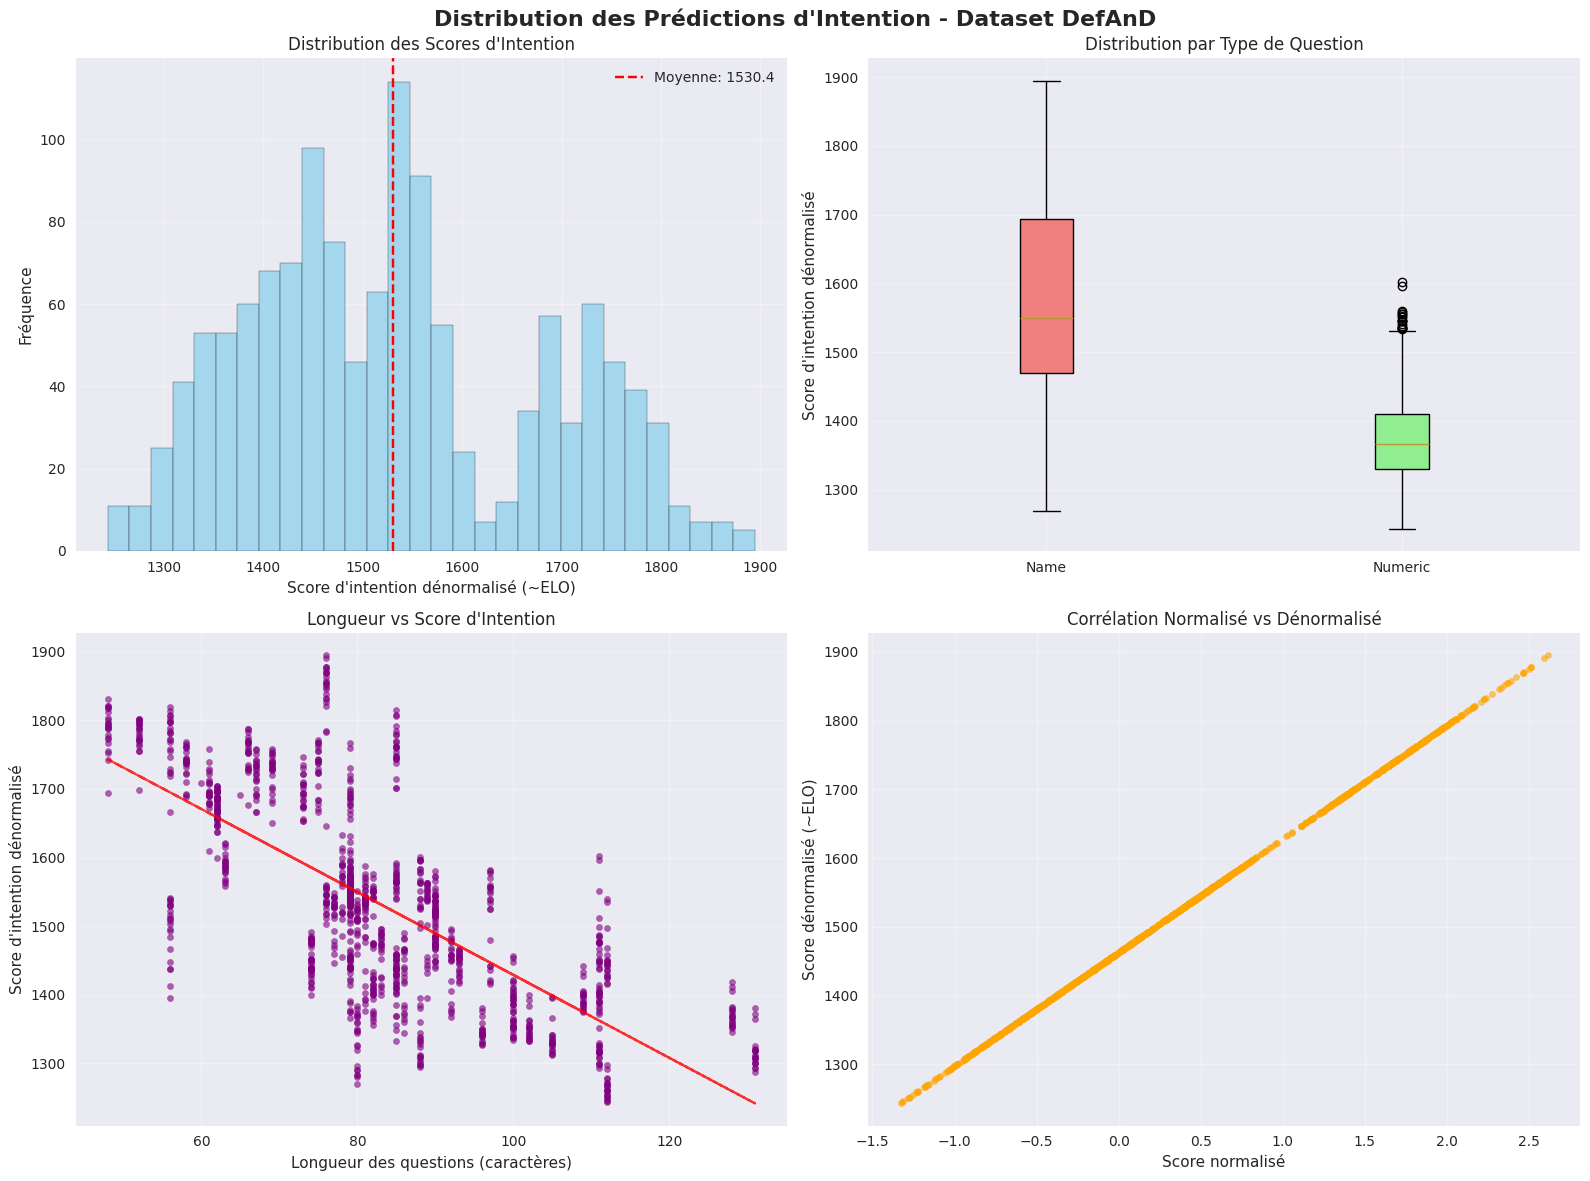

📊 STATISTIQUES DÉTAILLÉES DES PRÉDICTIONS D'INTENTION:
📈 Scores dénormalisés (ELO-like):
   • Moyenne: 1530.41
   • Médiane: 1519.51
   • Écart-type: 146.51
   • Min-Max: [1243.48, 1894.61]

🏷️ Analyse par type de question:
   • Type 'name':
     - Nombre: 1005
     - Moyenne: 1575.59
     - Écart-type: 131.93
   • Type 'numeric':
     - Nombre: 300
     - Moyenne: 1379.05
     - Écart-type: 72.98

🏆 TOP 5 - Questions avec le plus haut score d'intention:
   1. Score: 1894.6 | " Which stadium played host to the decisive match of the 2018..."
   2. Score: 1891.3 | " Which stadium played host to the decisive match of the 1978..."
   3. Score: 1877.7 | " Which stadium played host to the decisive match of the 1998..."
   4. Score: 1877.4 | " Which stadium played host to the decisive match of the 1982..."
   5. Score: 1875.4 | " Which stadium played host to the decisive match of the 1974..."

⬇️ BOTTOM 5 - Questions avec le plus bas score d'intention:
   1. Score: 1243.5 | " What was the siz

: 

In [ ]:
# Création d'un graphique de distribution des prédictions d'intention
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribution des Prédictions d\'Intention - Dataset DefAnD', fontsize=16, fontweight='bold')

# 1. Histogramme de la distribution des scores dénormalisés
axes[0, 0].hist(df_with_intent['intent_predicted_denormalized'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Score d\'intention dénormalisé (~ELO)')
axes[0, 0].set_ylabel('Fréquence')
axes[0, 0].set_title('Distribution des Scores d\'Intention')
axes[0, 0].axvline(df_with_intent['intent_predicted_denormalized'].mean(), color='red', linestyle='--', 
                   label=f'Moyenne: {df_with_intent["intent_predicted_denormalized"].mean():.1f}')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Box plot par type de question
name_scores = df_with_intent[df_with_intent['type'] == 'name']['intent_predicted_denormalized']
numeric_scores = df_with_intent[df_with_intent['type'] == 'numeric']['intent_predicted_denormalized']

bp = axes[0, 1].boxplot([name_scores, numeric_scores], labels=['Name', 'Numeric'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightcoral')
bp['boxes'][1].set_facecolor('lightgreen')
axes[0, 1].set_ylabel('Score d\'intention dénormalisé')
axes[0, 1].set_title('Distribution par Type de Question')
axes[0, 1].grid(alpha=0.3)

# 3. Scatter plot: longueur des questions vs score d'intention
question_lengths = df_with_intent['questions'].str.len()
axes[1, 0].scatter(question_lengths, df_with_intent['intent_predicted_denormalized'], 
                   alpha=0.6, s=20, color='purple')
axes[1, 0].set_xlabel('Longueur des questions (caractères)')
axes[1, 0].set_ylabel('Score d\'intention dénormalisé')
axes[1, 0].set_title('Longueur vs Score d\'Intention')
axes[1, 0].grid(alpha=0.3)

# Ligne de tendance
z = np.polyfit(question_lengths, df_with_intent['intent_predicted_denormalized'], 1)
p = np.poly1d(z)
axes[1, 0].plot(question_lengths, p(question_lengths), "r--", alpha=0.8)

# 4. Distribution des scores normalisés vs dénormalisés
axes[1, 1].scatter(df_with_intent['intent_predicted_normalized'], 
                   df_with_intent['intent_predicted_denormalized'], 
                   alpha=0.6, s=20, color='orange')
axes[1, 1].set_xlabel('Score normalisé')
axes[1, 1].set_ylabel('Score dénormalisé (~ELO)')
axes[1, 1].set_title('Corrélation Normalisé vs Dénormalisé')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiques détaillées
print("📊 STATISTIQUES DÉTAILLÉES DES PRÉDICTIONS D'INTENTION:")
print("=" * 60)

print(f"📈 Scores dénormalisés (ELO-like):")
print(f"   • Moyenne: {df_with_intent['intent_predicted_denormalized'].mean():.2f}")
print(f"   • Médiane: {df_with_intent['intent_predicted_denormalized'].median():.2f}")
print(f"   • Écart-type: {df_with_intent['intent_predicted_denormalized'].std():.2f}")
print(f"   • Min-Max: [{df_with_intent['intent_predicted_denormalized'].min():.2f}, {df_with_intent['intent_predicted_denormalized'].max():.2f}]")

print(f"\n🏷️ Analyse par type de question:")
for question_type in ['name', 'numeric']:
    subset = df_with_intent[df_with_intent['type'] == question_type]['intent_predicted_denormalized']
    print(f"   • Type '{question_type}':")
    print(f"     - Nombre: {len(subset)}")
    print(f"     - Moyenne: {subset.mean():.2f}")
    print(f"     - Écart-type: {subset.std():.2f}")

# Top et bottom questions par score d'intention
print(f"\n🏆 TOP 5 - Questions avec le plus haut score d'intention:")
top_intent = df_with_intent.nlargest(5, 'intent_predicted_denormalized')
for i, (idx, row) in enumerate(top_intent.iterrows(), 1):
    question = row['questions'][:60] + "..." if len(row['questions']) > 60 else row['questions']
    print(f"   {i}. Score: {row['intent_predicted_denormalized']:.1f} | \"{question}\"")

print(f"\n⬇️ BOTTOM 5 - Questions avec le plus bas score d'intention:")
bottom_intent = df_with_intent.nsmallest(5, 'intent_predicted_denormalized')
for i, (idx, row) in enumerate(bottom_intent.iterrows(), 1):
    question = row['questions'][:60] + "..." if len(row['questions']) > 60 else row['questions']
    print(f"   {i}. Score: {row['intent_predicted_denormalized']:.1f} | \"{question}\"")

# Corrélation avec la longueur des questions
correlation = np.corrcoef(df_with_intent['questions'].str.len(), 
                         df_with_intent['intent_predicted_denormalized'])[0, 1]
print(f"\n🔗 Corrélation longueur-intention: {correlation:.3f}")